## Imports

In [1]:
import pandas as pd
import re

In [2]:
from gensim import corpora
from gensim.corpora import Dictionary as d
from gensim.models import CoherenceModel, LdaMulticore
from gensim.parsing.preprocessing import preprocess_string

In [3]:

import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

In [4]:
# setting display options to maximum in order to display all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 0)
# disable chained assignments
pd.options.mode.chained_assignment = None 

## Functions

In [5]:
def preprocess_text(text):
    
    """
    Adjust input text. Removes html formatting, 
    dependent on gensim.parsing.preprocessing and re.
    
    Arguments:
    text      (str): words to be read in
    
    Returns:
    list of strings
    
    """
    
    # cast content to String
    text = str(text)
    
    # create spaces where we had a paragraph, remove tags
    text = text.replace('/n',' ').replace('&gt;','')
     
    # remove html tags
    text = re.sub(r'<[^>]+>', '', str(text))
    
    final_text = preprocess_string(text)
    
    return final_text
    

In [6]:
# exception to not start this if certain requirements (dictionary of weird characters) are met
def build_lda(seed, texts, num_topics):
    
    
    """
    Creates LDA model and prints all its topics.
    
    Arguments:
    seed          (int): seed number
    texts         (str): corpus of tokens
    num_topics    (int): amount of topics for the model
    
    Returns:
    bow_corpus    (obj): bag-of-words representation of text
    dictionary    (obj): dictionary of text
    lda_model     (obj): generated LDA model
    coherence     (float): coherence score of LDA model
    """
    
	#optional, in case data comes from a .csv:
    #texts = pd.read_csv(filename, names = colname ,converters = {'tweets': eval}, header = None, squeeze = True)
    #delete texts parameter accordingly
    dictionary = d(texts)
    print("-------------\n Output begins:")
    
    # remove words which appear <5 times in the dictionary + words which are more frequent than 10 per cent
    dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in texts]
    
    # workers should be "num physical processors"-1.
    lda_model = LdaMulticore(bow_corpus, random_state=seed, num_topics=num_topics, id2word=dictionary, passes=2, workers=3, per_word_topics=True)
    print("----\nLDA results:\nshown here:")
    for idx, topic in lda_model.print_topics(-1):
       print('Topic: {} \nWords: {}'.format(idx, topic))
    
    # Compute Perplexity and Coherence
    perplexity = lda_model.log_perplexity(bow_corpus)
    
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    
    print('\nPerplexity: ',perplexity, "\nCoherence:",coherence)
    print("---")


    return bow_corpus, dictionary, lda_model, coherence

In [210]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    
    
    """
    Formats ldamodel and its corpus to show dominant topics, 
    contributions and keywords per topic.
    
    Parameters:
    ldamodel          (obj): created LDA model
    corpus            (list): bow_corpus with frequency (list of tuples)
    texts             (list): list of strings
    
    Returns:
    DataFrame
    """
    
    # Init output
    sent_topics_df = pd.DataFrame()
    counter = 0
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                counter += 1
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                if counter%10000==0:
                    print('we are at {number:.{digits}f} per cent progress currently'.format(number=(counter/len(corpus))*100,digits=4))
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    # Format
    df_dominant_topic = sent_topics_df.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    df_dominant_topic.head(10)
    
    return(df_dominant_topic)


In [7]:
def plotly_wordcloud(text, amount_words):
    
    """
    Creates Word Cloud based on String of space-separated words.
    
    Parameters:
    text          (str): all text to include in word cloud
    amount_words  (int): max number of words to display 
    
    Returns:
    plotly.graph_objects_figure()
    """
    
    init_notebook_mode(connected=True)
    
    wc = WordCloud(stopwords = set(STOPWORDS),
                   max_words = amount_words,
                   max_font_size = 100)
    wc.generate(text)
    
    word_list=[]
    freq_list=[]
    fontsize_list=[]
    position_list=[]
    orientation_list=[]
    color_list=[]

    for (word, freq), fontsize, position, orientation, color in wc.layout_:
        word_list.append(word)
        freq_list.append(freq)
        fontsize_list.append(fontsize)
        position_list.append(position)
        orientation_list.append(orientation)
        color_list.append(color)
        
    # get the positions
    x=[]
    y=[]
    for i in position_list:
        x.append(i[0])
        y.append(i[1])
            
    # get the relative occurence frequencies
    new_freq_list = []
    for i in freq_list:
        new_freq_list.append(i*100)
    new_freq_list
    
    
   

    trace = go.Scatter(x=x, 
                       y=y, 
                       textfont = dict(size=new_freq_list,
                                       color=color_list),
                       hoverinfo='text',
                       hovertext=['{0} {1}'.format(w, f) for w, f in zip(word_list, freq_list)],
                       mode="text",  
                       text=word_list
                      )

    layout = go.Layout(
                       xaxis=dict(showgrid=False, 
                                  showticklabels=False,
                                  zeroline=False,
                                  automargin=True),
                       yaxis=dict(showgrid=False,
                                  showticklabels=False,
                                  zeroline=False,
                                  automargin=True)
                      )

    fig = go.Figure(data=[trace], layout=layout)
    
    return fig

#text = "Wikipedia was launched on January 15, 2001, by Jimmy Wales and Larry Sanger.[10] Sanger coined its name,[11][12] as a portmanteau of wiki[notes 3] and 'encyclopedia'. Initially an English-language encyclopedia, versions in other languages were quickly developed. With 5,748,461 articles,[notes 4] the English Wikipedia is the largest of the more than 290 Wikipedia encyclopedias. Overall, Wikipedia comprises more than 40 million articles in 301 different languages[14] and by February 2014 it had reached 18 billion page views and nearly 500 million unique visitors per month.[15] In 2005, Nature published a peer review comparing 42 science articles from Encyclopædia Britannica and Wikipedia and found that Wikipedia's level of accuracy approached that of Britannica.[16] Time magazine stated that the open-door policy of allowing anyone to edit had made Wikipedia the biggest and possibly the best encyclopedia in the world and it was testament to the vision of Jimmy Wales.[17] Wikipedia has been criticized for exhibiting systemic bias, for presenting a mixture of 'truths, half truths, and some falsehoods',[18] and for being subject to manipulation and spin in controversial topics.[19] In 2017, Facebook announced that it would help readers detect fake news by suitable links to Wikipedia articles. YouTube announced a similar plan in 2018."


#iplot(plotly_wordcloud(text))

---

In [8]:
dirpath = "C:/Users/NIKTO/test/QHSE/data/EDA/"

In [9]:
df = pd.read_csv(dirpath+'trans_application_losspotential_synergi_location_product(merged).csv')

In [10]:
df.head()

Unnamed: 0  case_no   trans         calenday_day  \
0  0           93038    539254  2015-05-04 09:30:00   
1  1           93031    539310  2015-04-30 09:00:00   
2  2           93032    539316  2015-04-30 00:00:00   
3  3           93032    539316  2015-04-30 00:00:00   
4  4           93393    540905  2015-05-09 08:00:00   

                                                                      title  \
0  BKR01 - Bullbay fender damaged during push on operations at location Q05   
1  Fenders on Coastal Knight                                                  
2  SHIMS for pendulum.                                                        
3  SHIMS for pendulum.                                                        
4  Hazardous Observation                                                      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
0  Whilst the bullbay was pushed on to Q05 push on tubes, the central part of the fender become loose and free from the main fender housing, the deckhand informed the master and the push on was seized immediately. The bullbay reported the damage to the site manager and it was agreed that the bullbay will head ashore so that the damage could be assessed but not before dropping equipment off at the regina baltica. During the transfer of equipment to the regina baltica, the all ready damaged fender came completely free from the housing and dropped into the water. All of the equipment was transferred safely and then the bullbay proceeded to shore. The fender was retrieved by another vessel and is now back oshore with the bullbay.   
1  Fenders on Coastal Knight are to small and the boat struggles to push on in minor waves.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2  Pendulum SHIMS are just in plastic bags and get damaged easily.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
3  Pendulum SHIMS are just in plastic bags and get damaged easily.                                                                                                                                                                               

In [11]:
df.drop(df.columns[0], axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181367 entries, 0 to 181366
Data columns (total 36 columns):
case_no                    181367 non-null int64
trans                      181367 non-null int64
calenday_day               179717 non-null object
title                      181367 non-null object
description                181367 non-null object
observer                   181367 non-null int64
shift                      181367 non-null int64
comments                   65690 non-null object
len_descr                  181367 non-null int64
application                181367 non-null int64
application_description    155891 non-null object
loss_potential_comments    13727 non-null object
consequence_type           92705 non-null float64
consequence_severity       92705 non-null float64
risk_area                  155889 non-null float64
location                   155889 non-null float64
unit_reported              155889 non-null float64
company_reported           155889 non-null f

In [13]:
len(df['case_no'].unique())

124113

In [14]:
df.dropna(subset=['application_description'], axis = 0, inplace=True)

In [15]:
#df.drop_duplicates(subset=['case_no'])

In [16]:
df.duplicated(subset=['case_no'])

0         False
1         False
2         False
3         True 
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        True 
13        False
14        True 
15        True 
16        True 
17        False
18        False
19        True 
20        False
21        False
22        False
23        False
24        False
25        True 
26        False
27        True 
28        False
29        False
30        True 
31        False
33        False
34        False
35        False
37        False
38        False
39        False
40        False
41        True 
42        False
43        False
44        False
45        False
46        False
47        True 
48        False
49        False
50        False
51        False
52        False
53        False
54        False
55        False
56        False
57        False
58        False
59        False
60        False
61        False
62        False
63        True 
66      

In [17]:
df[df['case_no'] == 213198]

case_no    trans         calenday_day  \
66925   213198   1454944  2020-04-13 00:00:00   
66926   213198   1454944  2020-04-13 00:00:00   
66927   213198   1454944  2020-04-13 00:00:00   
181334  213198   1454944  2020-04-13 00:00:00   
181335  213198   1454944  2020-04-13 00:00:00   
181336  213198   1454944  2020-04-13 00:00:00   

                                    title  \
66925   Quality issue with Hydraulic Hose   
66926   Quality issue with Hydraulic Hose   
66927   Quality issue with Hydraulic Hose   
181334  Quality issue with Hydraulic Hose   
181335  Quality issue with Hydraulic Hose   
181336  Quality issue with Hydraulic Hose   

                                                                                                                                                                                                                                                                             description  \
66925   A recently procured new Hydraulic hose for the Palfinger PCWM crane was found to be unfit for purpose.\r\nReason appears to be poor swaging of the sleeve and union onto the Hydraulic hose. \r\nIssue was found when system was re pressurized for the replacement of the hose.   
66926   A recently procured new Hydraulic hose for the Palfinger PCWM crane was found to be unfit for purpose.\r\nReason appears to be poor swaging of the sleeve and union onto the Hydraulic hose. \r\nIssue was found when system was re pressurized for the replacement of the hose.   
66927   A recently procured new Hydraulic hose for the Palfinger PCWM crane was found to be unfit for purpose.\r\nReason appears to be poor swaging of the sleeve and union onto the Hydraulic hose. \r\nIssue was found when system was re pressurized for the replacement of the hose.   
181334  A recently procured new Hydraulic hose for the Palfinger PCWM crane was found to be unfit for purpose.\r\nReason appears to be poor swaging of the sleeve and union onto the Hydraulic hose. \r\nIssue was found when system was re pressurized for the replacement of the hose.   
181335  A recently procured new Hydraulic hose for the Palfinger PCWM crane was found to be unfit for purpose.\r\nReason appears to be poor swaging of the sleeve and union onto the Hydraulic hose. \r\nIssue was found when system was re pressurized for the replacement of the hose.   
181336  A recently procured new Hydraulic hose for the Palfinger PCWM crane was found to be unfit for purpose.\r\nReason appears to be poor swaging of the sleeve and union onto the Hydraulic hose. \r\nIssue was found when system was re pressurized for the replacement of the hose.   

        observer  shift  \
66925   0         0       
66926   0         0       
66927   0         0       
181334  0         0       
181335  0         0       
181336  0         0       

                                                     comments  len_descr  \
66925   NaN                                                    268         
66926   NaN                                                    268         
66927   NaN                                                    268         
181334  RAPJO 12-11-2020 Hazard added. Case reopened & closed  268         
181335  RAPJO 12-11-2020 Hazard added. Case reopened & closed  268         
181336  RAPJO 12-11-2020 Hazard added. Case reopened & closed  268         

        application                  application_description  \
66925   22           1. Incident - 3. Observation, Condition   
66926   22           1. Incident - 3. Observation, Condition   
66927   22           1. Incident - 3. Observation, Condition   
181334  22           1. Incident - 3. Observation, Condition   
181335  22           1. Incident - 3. Observation, Condition   
181336  22           1. Incident - 3. Observation, Condition   

       loss_potential_comments  consequence_type  consequence_severity  \
66925   NaN                     2.0               50035.0                
66926   NaN                     50003.0

In [18]:
df['duplicate'] = df.duplicated(subset=['case_no'])

In [19]:
df.head(1)

case_no   trans         calenday_day  \
0  93038    539254  2015-05-04 09:30:00   

                                                                      title  \
0  BKR01 - Bullbay fender damaged during push on operations at location Q05   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
0  Whilst the bullbay was pushed on to Q05 push on tubes, the central part of the fender become loose and free from the main fender housing, the deckhand informed the master and the push on was seized immediately. The bullbay reported the damage to the site manager and it was agreed that the bullbay will head ashore so that the damage could be assessed but not before dropping equipment off at the regina baltica. During the transfer of equipment to the regina baltica, the all ready damaged fender came completely free from the housing and dropped into the water. All of the equipment was transferred safely and then the bullbay proceeded to shore. The fender was retrieved by another vessel and is now back oshore with the bullbay.   

   observer  shift comments  len_descr  application  \
0  0         0      NaN      732        22            

                   application_description         loss_potential_comments  \
0  1. Incident - 3. Observation, Condition  Cost of fender approx 7.000GBP   

   consequence_type  consequence_severity  risk_area  location  unit_reported  \
0  50003.0           50037.0               0.0        1121.0    1410.0          

   company_reported  customer  chemicals_involved contact_person  notified  \
0  737.0             0.0       0.0                 NaN            0.0        

   investigated start_date end_date  discovered  actual_hazard  process  \
0  0.0           NaN        NaN      0.0         0.0            0.0       

   product  control_doc  \
0  0.0      0.0           

                                                                                                                                                                                                      causes_descr  \
0  Vessel fender had been altered to suit requirements for offshore safety distances, which then affected the integrity of the outer surface of the fender, which when being worked over time loosened the fender.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  suggestion  \
0  PC - The section of the fender which was damaged was not the main part for gaining grip to the push on tubes, but when damaged had potential to become a trip hazard when transferring - When the fender eventially dropped off and entered the water it became a floating hazard to other vessels in the windfarm with potential for collision and damage to other vessels.

In [20]:
# remove all duplicate case_numbers
df = df[df['duplicate']==False]

In [21]:
df.shape

(110764, 37)

In [22]:
# use title, description as main input for topic modeling.
import time

start = time.time()

df['title_cleaned'] = df['title'].apply(preprocess_text)
end = time.time()

print('Cleaning took {} seconds'.format(round(end-start,2)))


Cleaning took 5.34 seconds


In [23]:
df['description_cleaned'] = df['description'].apply(preprocess_text)

In [24]:
# comments column is optional but why not for now:
df['comments_cleaned'] = df['comments'].apply(preprocess_text)

In [25]:
df[['title_cleaned','description_cleaned','comments_cleaned']].head(2)

title_cleaned  \
0  [bkr, bullbai, fender, damag, push, oper, locat]   
1  [fender, coastal, knight]                          

                                                                                                                                                                                                                                                                                                                                                                                                                         description_cleaned  \
0  [whilst, bullbai, push, push, tube, central, fender, loos, free, main, fender, hous, deckhand, inform, master, push, seiz, immedi, bullbai, report, damag, site, manag, agre, bullbai, head, ashor, damag, assess, drop, equip, regina, baltica, transfer, equip, regina, baltica, readi, damag, fender, came, complet, free, hous, drop, water, equip, transfer, safe, bullbai, proceed, shore, fender, retriev, vessel, oshor, bullbai]   
1  [fender, coastal, knight, small, boat, struggl, push, minor, wave]                                                                                                                                                                                                                                                                                                                                                                          

  comments_cleaned  
0  [nan]            
1  [nan]

## Get LDA models and coherences

In [26]:
help(build_lda)

Help on function build_lda in module __main__:

build_lda(seed, texts, num_topics)
    Creates LDA model and prints all its topics.
    
    Arguments:
    seed          (int): seed number
    texts         (str): corpus of tokens
    num_topics    (int): amount of topics for the model
    
    Returns:
    bow_corpus    (obj): bag-of-words representation of text
    dictionary    (obj): dictionary of text
    lda_model     (obj): generated LDA model
    coherence     (float): coherence score of LDA model



In [27]:
column_names = ['title_cleaned', 'description_cleaned', 'comments_cleaned']

In [28]:
# moving the dataframe columns into list of lists and storing it in a list
corpus_list = []

for column in column_names:
    corpus_list.append(df[column].tolist())

In [207]:
len(corpus_list)

3

In [29]:
# accessing the second row of title_cleaned
corpus_list[0][1]

['fender', 'coastal', 'knight']

In [32]:
# test for one topic and title_cleaned
test = build_lda(42, corpus_list[0], 1)

-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.015*"safeti" + 0.014*"inspect" + 0.012*"hse" + 0.009*"work" + 0.009*"site" + 0.008*"cabl" + 0.008*"vessel" + 0.007*"onshor" + 0.007*"meet" + 0.007*"oper"

Perplexity:  -7.171379944464969 
Coherence: 0.31321989649938764
---


In [33]:
test

([[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
  [(2, 1), (6, 1), (7, 1)],
  [(8, 1), (9, 1)],
  [(10, 1), (11, 1)],
  [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2)],
  [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1)],
  [(26, 1), (27, 1), (28, 1), (29, 1)],
  [(30, 1), (31, 1), (32, 1)],
  [(3, 1),
   (33, 1),
   (34, 1),
   (35, 1),
   (36, 1),
   (37, 1),
   (38, 1),
   (39, 1),
   (40, 1),
   (41, 1),
   (42, 1),
   (43, 1),
   (44, 1),
   (45, 1)],
  [(19, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)],
  [(52, 1), (53, 1), (54, 1), (55, 1), (56, 1)],
  [(57, 1), (58, 1), (59, 1), (60, 1)],
  [(19, 1), (46, 1), (49, 1), (61, 1), (62, 1), (63, 1), (64, 1)],
  [(54, 1),
   (65, 1),
   (66, 1),
   (67, 1),
   (68, 1),
   (69, 1),
   (70, 1),
   (71, 1),
   (72, 1)],
  [(73, 1), (74, 1)],
  [(13, 1),
   (75, 1),
   (76, 1),
   (77, 1),
   (78, 1),
   (79, 1),
   (80, 1),
   (81, 1),
   (82, 1),
   (83, 1)],
  [(0, 1),
   (43, 1),
   (84,

In [43]:
def perform_lda_and_return_results(corpus):

    start = time.time() 

    lda_results = []

    # using a large range of topics for testing, this will take a while
    for i in range(2,42):

        lda_results.append(build_lda(42, corpus, i))

        # naive progress timer
        print('Current progress is {} per cent'.format(i-1/40*100))   
        

    end = time.time()

    print('LDA for up to {} topics took {} seconds'.format(i,round(end-start,2)))
    
    return lda_results

In [46]:
title_results = perform_lda_and_return_results(corpus_list[0])

-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.028*"safeti" + 0.024*"inspect" + 0.016*"work" + 0.013*"substat" + 0.013*"onshor" + 0.011*"drill" + 0.010*"vessel" + 0.009*"hse" + 0.007*"wtg" + 0.007*"observ"
Topic: 1 
Words: 0.016*"site" + 0.016*"cabl" + 0.015*"hse" + 0.014*"meet" + 0.013*"lift" + 0.008*"crane" + 0.008*"ncr" + 0.007*"oper" + 0.007*"damag" + 0.007*"access"

Perplexity:  -7.2105675356173 
Coherence: 0.26309319809841963
---
Current progress is 4.761904761904762 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.024*"work" + 0.017*"substat" + 0.015*"onshor" + 0.011*"hse" + 0.011*"inspect" + 0.010*"good" + 0.010*"manag" + 0.009*"observ" + 0.009*"wtg" + 0.008*"oper"
Topic: 1 
Words: 0.023*"hse" + 0.023*"cabl" + 0.022*"site" + 0.019*"meet" + 0.018*"lift" + 0.012*"crane" + 0.011*"oper" + 0.010*"access" + 0.009*"inspect" + 0.008*"damag"
Topic: 2 
Words: 0.039*"safeti" + 0.022*"inspect" + 0.015*"drill" + 0.014*"n


Perplexity:  -7.296329565569364 
Coherence: 0.2434514588510615
---
Current progress is 21.428571428571427 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.048*"substat" + 0.042*"onshor" + 0.023*"ppe" + 0.023*"hoc" + 0.023*"emerg" + 0.020*"good" + 0.019*"work" + 0.016*"equip" + 0.015*"light" + 0.014*"oper"
Topic: 1 
Words: 0.061*"cabl" + 0.051*"lift" + 0.032*"crane" + 0.018*"us" + 0.017*"oper" + 0.014*"bag" + 0.014*"rout" + 0.013*"site" + 0.013*"damag" + 0.011*"onshor"
Topic: 2 
Words: 0.026*"area" + 0.024*"oil" + 0.016*"leak" + 0.014*"store" + 0.013*"sea" + 0.013*"drill" + 0.012*"tern" + 0.012*"test" + 0.012*"swp" + 0.011*"bold"
Topic: 3 
Words: 0.091*"hse" + 0.086*"meet" + 0.061*"ncr" + 0.025*"weekli" + 0.023*"agenda" + 0.018*"manag" + 0.018*"chw" + 0.014*"flang" + 0.012*"gm" + 0.012*"handl"
Topic: 4 
Words: 0.124*"safeti" + 0.109*"inspect" + 0.032*"hse" + 0.031*"walk" + 0.031*"site" + 0.019*"vessel" + 0.019*"weekli" + 0.014*"drill" + 0.012*"ons


Perplexity:  -7.561835353974697 
Coherence: 0.2878142686334737
---
Current progress is 30.952380952380953 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.041*"emerg" + 0.037*"wtg" + 0.029*"instal" + 0.028*"light" + 0.026*"sea" + 0.025*"drill" + 0.020*"sgre" + 0.017*"respons" + 0.017*"exercis" + 0.016*"commiss"
Topic: 1 
Words: 0.060*"lift" + 0.037*"crane" + 0.023*"cabl" + 0.022*"oper" + 0.019*"bag" + 0.019*"us" + 0.015*"drop" + 0.015*"damag" + 0.014*"davit" + 0.013*"wire"
Topic: 2 
Words: 0.034*"oil" + 0.024*"area" + 0.023*"leak" + 0.022*"store" + 0.018*"fugro" + 0.015*"hydraul" + 0.014*"alarm" + 0.013*"hose" + 0.013*"ga" + 0.013*"spill"
Topic: 3 
Words: 0.133*"hse" + 0.129*"meet" + 0.037*"agenda" + 0.036*"weekli" + 0.028*"handl" + 0.019*"contractor" + 0.017*"manag" + 0.014*"sdm" + 0.014*"box" + 0.014*"manual"
Topic: 4 
Words: 0.044*"drill" + 0.043*"train" + 0.022*"talk" + 0.021*"construct" + 0.021*"site" + 0.018*"rescu" + 0.018*"park" + 0.016*"


Perplexity:  -7.721514104745028 
Coherence: 0.3051974109962333
---
Current progress is 38.095238095238095 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.045*"ppe" + 0.034*"light" + 0.031*"hatch" + 0.030*"work" + 0.027*"safe" + 0.023*"loos" + 0.023*"nacel" + 0.021*"wear" + 0.019*"sub" + 0.018*"correct"
Topic: 1 
Words: 0.048*"crane" + 0.044*"cabl" + 0.039*"us" + 0.025*"rout" + 0.021*"oper" + 0.019*"hinterland" + 0.018*"davit" + 0.017*"kit" + 0.017*"aid" + 0.015*"lift"
Topic: 2 
Words: 0.035*"oil" + 0.027*"area" + 0.025*"leak" + 0.024*"drill" + 0.022*"drop" + 0.021*"wast" + 0.017*"weather" + 0.016*"hydraul" + 0.015*"object" + 0.015*"hoc"
Topic: 3 
Words: 0.040*"bag" + 0.040*"lift" + 0.036*"handl" + 0.030*"load" + 0.023*"box" + 0.022*"offshor" + 0.019*"failur" + 0.019*"vesta" + 0.019*"lead" + 0.018*"tool"
Topic: 4 
Words: 0.044*"train" + 0.037*"report" + 0.035*"fugro" + 0.028*"talk" + 0.024*"survei" + 0.022*"drill" + 0.022*"osa" + 0.022*"case" + 0


Perplexity:  -7.830955220773624 
Coherence: 0.29441624414893425
---
Current progress is 45.23809523809524 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.064*"good" + 0.058*"emerg" + 0.041*"commun" + 0.032*"safe" + 0.031*"drill" + 0.030*"work" + 0.027*"rescu" + 0.025*"team" + 0.024*"exercis" + 0.024*"respons"
Topic: 1 
Words: 0.100*"lift" + 0.053*"crane" + 0.041*"oper" + 0.038*"us" + 0.029*"bag" + 0.021*"davit" + 0.019*"equip" + 0.019*"tool" + 0.018*"cabl" + 0.017*"hinterland"
Topic: 2 
Words: 0.044*"oil" + 0.036*"wast" + 0.030*"leak" + 0.027*"water" + 0.026*"swp" + 0.020*"hydraul" + 0.017*"hose" + 0.017*"spill" + 0.014*"gener" + 0.012*"alarm"
Topic: 3 
Words: 0.035*"handl" + 0.034*"chw" + 0.031*"box" + 0.026*"ncr" + 0.024*"sdm" + 0.021*"engin" + 0.018*"manual" + 0.018*"weld" + 0.016*"repair" + 0.015*"ey"
Topic: 4 
Words: 0.038*"fugro" + 0.033*"talk" + 0.027*"report" + 0.024*"enterpris" + 0.023*"toolbox" + 0.023*"case" + 0.023*"construct" + 0.02


Perplexity:  -7.91458819228436 
Coherence: 0.3164243400584297
---
Current progress is 52.38095238095239 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.075*"emerg" + 0.040*"commun" + 0.035*"sub" + 0.034*"risk" + 0.032*"respons" + 0.031*"drill" + 0.030*"line" + 0.029*"exercis" + 0.022*"station" + 0.018*"offshor"
Topic: 1 
Words: 0.113*"lift" + 0.063*"crane" + 0.038*"us" + 0.035*"oper" + 0.034*"bag" + 0.027*"drop" + 0.024*"davit" + 0.021*"object" + 0.019*"date" + 0.019*"kit"
Topic: 2 
Words: 0.045*"oil" + 0.032*"leak" + 0.030*"water" + 0.021*"hydraul" + 0.021*"hose" + 0.021*"clean" + 0.020*"wast" + 0.019*"weather" + 0.016*"condit" + 0.015*"spill"
Topic: 3 
Words: 0.058*"store" + 0.035*"innov" + 0.028*"jacket" + 0.025*"failur" + 0.024*"life" + 0.022*"boat" + 0.022*"load" + 0.020*"ga" + 0.019*"coshh" + 0.018*"fou"
Topic: 4 
Words: 0.050*"onss" + 0.034*"fugro" + 0.032*"talk" + 0.027*"orst" + 0.027*"enterpris" + 0.027*"park" + 0.026*"toolbox" + 0.024*


Perplexity:  -8.004441178368099 
Coherence: 0.3260657370122591
---
Current progress is 57.14285714285714 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.094*"drill" + 0.079*"emerg" + 0.053*"light" + 0.035*"scaffold" + 0.032*"rescu" + 0.032*"respons" + 0.032*"exercis" + 0.026*"line" + 0.017*"pioneer" + 0.016*"evacu"
Topic: 1 
Words: 0.066*"crane" + 0.060*"us" + 0.050*"lift" + 0.028*"kit" + 0.027*"davit" + 0.022*"life" + 0.019*"oper" + 0.019*"blade" + 0.018*"jacket" + 0.017*"broken"
Topic: 2 
Words: 0.042*"oil" + 0.030*"clean" + 0.027*"leak" + 0.025*"hydraul" + 0.024*"hose" + 0.024*"alarm" + 0.021*"weather" + 0.017*"spill" + 0.017*"normand" + 0.016*"water"
Topic: 3 
Words: 0.092*"offshor" + 0.047*"technician" + 0.041*"sub" + 0.040*"oss" + 0.028*"contractor" + 0.026*"wd" + 0.025*"cut" + 0.024*"station" + 0.023*"vesta" + 0.014*"pallet"
Topic: 4 
Words: 0.085*"hoc" + 0.059*"store" + 0.058*"fugro" + 0.029*"enterpris" + 0.027*"park" + 0.025*"storag" + 


Perplexity:  -8.045527404394047 
Coherence: 0.33408278865355207
---
Current progress is 61.904761904761905 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.075*"emerg" + 0.047*"hatch" + 0.047*"light" + 0.040*"drill" + 0.038*"safe" + 0.032*"exercis" + 0.031*"respons" + 0.025*"rescu" + 0.023*"practic" + 0.023*"nacel"
Topic: 1 
Words: 0.054*"us" + 0.041*"drop" + 0.034*"wast" + 0.033*"object" + 0.026*"repair" + 0.024*"remov" + 0.019*"lift" + 0.017*"lead" + 0.017*"rope" + 0.017*"hmc"
Topic: 2 
Words: 0.037*"test" + 0.032*"osa" + 0.030*"hub" + 0.029*"alarm" + 0.023*"hose" + 0.022*"east" + 0.019*"neptun" + 0.018*"card" + 0.018*"coast" + 0.016*"geo"
Topic: 3 
Words: 0.043*"load" + 0.033*"box" + 0.026*"life" + 0.025*"cut" + 0.025*"wd" + 0.024*"jacket" + 0.022*"paint" + 0.020*"sling" + 0.019*"block" + 0.016*"offshor"
Topic: 4 
Words: 0.061*"train" + 0.052*"fugro" + 0.045*"talk" + 0.033*"enterpris" + 0.032*"park" + 0.031*"toolbox" + 0.029*"safeti" + 0.026*"


Perplexity:  -8.130788962196585 
Coherence: 0.33064123690907216
---
Current progress is 66.66666666666666 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.108*"emerg" + 0.045*"respons" + 0.044*"exercis" + 0.041*"drill" + 0.036*"line" + 0.033*"equip" + 0.020*"recoveri" + 0.020*"evacu" + 0.018*"tag" + 0.017*"item"
Topic: 1 
Words: 0.148*"lift" + 0.051*"wast" + 0.046*"bag" + 0.031*"aid" + 0.028*"oper" + 0.026*"kit" + 0.021*"deme" + 0.021*"jacket" + 0.017*"rope" + 0.017*"date"
Topic: 2 
Words: 0.048*"test" + 0.041*"store" + 0.030*"alarm" + 0.028*"drill" + 0.027*"park" + 0.025*"car" + 0.025*"swp" + 0.022*"muster" + 0.022*"near" + 0.021*"ga"
Topic: 3 
Words: 0.068*"handl" + 0.056*"load" + 0.041*"need" + 0.032*"manual" + 0.026*"monitor" + 0.024*"boskali" + 0.022*"awar" + 0.019*"asset" + 0.019*"updat" + 0.019*"stand"
Topic: 4 
Words: 0.049*"train" + 0.045*"hub" + 0.042*"talk" + 0.033*"miss" + 0.033*"osa" + 0.030*"toolbox" + 0.028*"fenc" + 0.025*"east" + 


Perplexity:  -8.207065269863795 
Coherence: 0.31771783592421593
---
Current progress is 71.42857142857143 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.095*"emerg" + 0.076*"drill" + 0.052*"protect" + 0.047*"sub" + 0.040*"exercis" + 0.039*"respons" + 0.033*"rescu" + 0.033*"station" + 0.032*"hatch" + 0.032*"person"
Topic: 1 
Words: 0.151*"lift" + 0.049*"bag" + 0.046*"us" + 0.042*"equip" + 0.036*"date" + 0.034*"kit" + 0.027*"aid" + 0.021*"oper" + 0.018*"rope" + 0.017*"sling"
Topic: 2 
Words: 0.045*"clean" + 0.034*"alarm" + 0.034*"park" + 0.026*"car" + 0.025*"excav" + 0.022*"provid" + 0.022*"area" + 0.020*"cabin" + 0.017*"welfar" + 0.017*"vehicl"
Topic: 3 
Words: 0.088*"offshor" + 0.048*"load" + 0.034*"foundat" + 0.025*"wd" + 0.025*"follow" + 0.019*"data" + 0.017*"oss" + 0.015*"prepar" + 0.015*"bsw" + 0.015*"packag"
Topic: 4 
Words: 0.049*"survei" + 0.043*"enterpris" + 0.041*"engin" + 0.033*"njord" + 0.031*"case" + 0.028*"locat" + 0.026*"fou" + 0.


Perplexity:  -8.266624721583291 
Coherence: 0.3359475858418716
---
Current progress is 76.19047619047619 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.082*"emerg" + 0.078*"drill" + 0.064*"light" + 0.039*"rescu" + 0.039*"sub" + 0.037*"condit" + 0.033*"exercis" + 0.032*"respons" + 0.030*"station" + 0.030*"weather"
Topic: 1 
Words: 0.052*"blade" + 0.048*"handl" + 0.041*"broken" + 0.039*"wire" + 0.030*"worker" + 0.029*"rope" + 0.026*"transit" + 0.022*"manual" + 0.021*"piec" + 0.017*"damag"
Topic: 2 
Words: 0.078*"oil" + 0.049*"leak" + 0.036*"hydraul" + 0.035*"hose" + 0.030*"spill" + 0.021*"approv" + 0.020*"boskali" + 0.019*"provid" + 0.019*"gear" + 0.017*"pipe"
Topic: 3 
Words: 0.162*"lift" + 0.065*"bag" + 0.045*"box" + 0.044*"tool" + 0.029*"oper" + 0.027*"equip" + 0.023*"sling" + 0.020*"lewek" + 0.020*"connector" + 0.020*"failur"
Topic: 4 
Words: 0.067*"sim" + 0.059*"scaffold" + 0.049*"survei" + 0.043*"board" + 0.043*"locat" + 0.031*"monitor" + 0


Perplexity:  -8.360573533383654 
Coherence: 0.33993452373385324
---
Current progress is 80.95238095238095 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.099*"emerg" + 0.052*"safe" + 0.043*"risk" + 0.041*"exercis" + 0.041*"good" + 0.040*"respons" + 0.034*"drill" + 0.032*"work" + 0.025*"plan" + 0.023*"practic"
Topic: 1 
Words: 0.160*"lift" + 0.063*"wast" + 0.044*"bag" + 0.038*"kit" + 0.034*"aid" + 0.031*"oper" + 0.030*"date" + 0.021*"hmc" + 0.019*"hinderland" + 0.015*"bin"
Topic: 2 
Words: 0.082*"oil" + 0.056*"leak" + 0.044*"clean" + 0.041*"area" + 0.037*"hydraul" + 0.036*"hose" + 0.029*"fuel" + 0.026*"spill" + 0.021*"intertid" + 0.019*"compound"
Topic: 3 
Words: 0.065*"handl" + 0.059*"load" + 0.031*"manual" + 0.025*"ey" + 0.023*"wash" + 0.022*"bottl" + 0.021*"carri" + 0.020*"vessel" + 0.018*"incorrectli" + 0.017*"stand"
Topic: 4 
Words: 0.071*"report" + 0.051*"case" + 0.029*"covid" + 0.029*"tech" + 0.028*"head" + 0.025*"synergi" + 0.024*"heli" +


Perplexity:  -8.421424513790297 
Coherence: 0.35790167956381885
---
Current progress is 85.71428571428571 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.097*"ppe" + 0.075*"equip" + 0.055*"safe" + 0.054*"wear" + 0.053*"person" + 0.049*"protect" + 0.038*"correct" + 0.035*"work" + 0.022*"oper" + 0.018*"practic"
Topic: 1 
Words: 0.117*"lift" + 0.093*"good" + 0.075*"us" + 0.047*"oper" + 0.034*"construct" + 0.031*"life" + 0.028*"jacket" + 0.023*"ey" + 0.022*"repair" + 0.021*"wash"
Topic: 2 
Words: 0.058*"condit" + 0.033*"hose" + 0.028*"plant" + 0.026*"ground" + 0.025*"spill" + 0.025*"base" + 0.024*"ga" + 0.022*"conduct" + 0.021*"cross" + 0.019*"bottl"
Topic: 3 
Words: 0.070*"handl" + 0.060*"box" + 0.054*"load" + 0.053*"tool" + 0.039*"wd" + 0.038*"monitor" + 0.034*"manual" + 0.031*"learn" + 0.027*"lesson" + 0.026*"approv"
Topic: 4 
Words: 0.095*"train" + 0.047*"survei" + 0.040*"park" + 0.032*"car" + 0.029*"onboard" + 0.027*"locat" + 0.026*"ørsted" + 0


Perplexity:  -8.46859836887512 
Coherence: 0.33604717023455066
---
Current progress is 90.47619047619048 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.110*"emerg" + 0.102*"light" + 0.062*"sub" + 0.053*"respons" + 0.052*"exercis" + 0.050*"station" + 0.047*"line" + 0.025*"drill" + 0.021*"command" + 0.020*"helicopt"
Topic: 1 
Words: 0.147*"lift" + 0.109*"crane" + 0.057*"oper" + 0.040*"davit" + 0.039*"wire" + 0.021*"damag" + 0.020*"sling" + 0.020*"blade" + 0.020*"us" + 0.020*"hmc"
Topic: 2 
Words: 0.072*"assess" + 0.046*"ctv" + 0.040*"wind" + 0.037*"risk" + 0.035*"weather" + 0.032*"oper" + 0.031*"alarm" + 0.031*"sign" + 0.028*"swp" + 0.028*"extinguish"
Topic: 3 
Words: 0.081*"handl" + 0.056*"wd" + 0.055*"load" + 0.038*"manual" + 0.030*"geosea" + 0.023*"earth" + 0.022*"offshor" + 0.021*"fish" + 0.021*"awp" + 0.020*"prepar"
Topic: 4 
Words: 0.070*"hub" + 0.057*"hinterland" + 0.040*"tkte" + 0.037*"east" + 0.032*"head" + 0.032*"record" + 0.029*"coast"


Perplexity:  -8.558463132341725 
Coherence: 0.36680860879346316
---
Current progress is 95.23809523809523 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.120*"emerg" + 0.076*"condit" + 0.064*"sub" + 0.064*"drop" + 0.054*"exercis" + 0.053*"respons" + 0.052*"object" + 0.044*"weather" + 0.042*"station" + 0.038*"drill"
Topic: 1 
Words: 0.063*"aid" + 0.059*"kit" + 0.038*"ey" + 0.035*"date" + 0.033*"wash" + 0.033*"replac" + 0.026*"worker" + 0.021*"broken" + 0.021*"expos" + 0.020*"injuri"
Topic: 2 
Words: 0.048*"hose" + 0.041*"engin" + 0.031*"lal" + 0.030*"maersk" + 0.029*"pipe" + 0.028*"unit" + 0.027*"cabin" + 0.027*"hydraul" + 0.026*"damag" + 0.026*"electr"
Topic: 3 
Words: 0.099*"lift" + 0.086*"bag" + 0.078*"handl" + 0.039*"edg" + 0.037*"manual" + 0.022*"paint" + 0.020*"fish" + 0.020*"flower" + 0.018*"vessel" + 0.018*"prepar"
Topic: 4 
Words: 0.126*"train" + 0.034*"safeti" + 0.031*"brief" + 0.030*"obstruct" + 0.025*"client" + 0.024*"move" + 0.023*"o

In [47]:
description_results = perform_lda_and_return_results(corpus_list[1])

-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.009*"team" + 0.008*"hse" + 0.008*"vessel" + 0.008*"requir" + 0.007*"manag" + 0.007*"report" + 0.006*"document" + 0.006*"attach" + 0.006*"contractor" + 0.006*"oper"
Topic: 1 
Words: 0.011*"area" + 0.010*"lift" + 0.009*"deck" + 0.009*"observ" + 0.008*"walk" + 0.008*"oper" + 0.008*"vessel" + 0.007*"meet" + 0.007*"cabl" + 0.006*"crane"

Perplexity:  -7.410204849830788 
Coherence: 0.4426650607697117
---
Current progress is 4.761904761904762 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.010*"requir" + 0.009*"manag" + 0.009*"document" + 0.008*"project" + 0.007*"contractor" + 0.007*"test" + 0.006*"team" + 0.006*"attach" + 0.006*"report" + 0.005*"time"
Topic: 1 
Words: 0.009*"cabl" + 0.009*"area" + 0.007*"deck" + 0.007*"caus" + 0.006*"access" + 0.006*"oper" + 0.006*"lift" + 0.006*"damag" + 0.005*"place" + 0.005*"water"
Topic: 2 
Words: 0.023*"vessel" + 0.017*"hse" + 0.015*"me


Perplexity:  -7.322145711863952 
Coherence: 0.6016695342779177
---
Current progress is 21.428571428571427 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.017*"team" + 0.016*"technician" + 0.013*"turbin" + 0.013*"dai" + 0.012*"time" + 0.009*"emerg" + 0.006*"tech" + 0.005*"need" + 0.005*"wind" + 0.005*"servic"
Topic: 1 
Words: 0.069*"meet" + 0.050*"walk" + 0.049*"incid" + 0.049*"hse" + 0.044*"assess" + 0.044*"plan" + 0.040*"environment" + 0.040*"health" + 0.037*"process" + 0.026*"miss"
Topic: 2 
Words: 0.041*"lift" + 0.023*"crane" + 0.020*"oper" + 0.016*"bag" + 0.013*"ladder" + 0.012*"load" + 0.010*"fall" + 0.010*"deck" + 0.009*"hook" + 0.009*"access"
Topic: 3 
Words: 0.020*"cabl" + 0.013*"door" + 0.011*"area" + 0.011*"hazard" + 0.011*"caus" + 0.011*"trip" + 0.010*"open" + 0.010*"bolt" + 0.009*"left" + 0.008*"floor"
Topic: 4 
Words: 0.017*"area" + 0.017*"oil" + 0.015*"contain" + 0.015*"store" + 0.014*"wast" + 0.013*"water" + 0.013*"clean" + 0.012*


Perplexity:  -7.401199520563805 
Coherence: 0.5951482095735463
---
Current progress is 30.952380952380953 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.017*"technician" + 0.016*"team" + 0.015*"dai" + 0.013*"time" + 0.013*"turbin" + 0.009*"emerg" + 0.006*"tech" + 0.006*"inform" + 0.006*"wind" + 0.005*"weather"
Topic: 1 
Words: 0.076*"meet" + 0.052*"hse" + 0.052*"incid" + 0.051*"walk" + 0.048*"plan" + 0.048*"assess" + 0.045*"environment" + 0.044*"health" + 0.040*"process" + 0.025*"miss"
Topic: 2 
Words: 0.056*"lift" + 0.031*"crane" + 0.026*"oper" + 0.023*"bag" + 0.016*"load" + 0.012*"hook" + 0.011*"deck" + 0.010*"equip" + 0.010*"ladder" + 0.009*"rope"
Topic: 3 
Words: 0.017*"caus" + 0.015*"deck" + 0.013*"hazard" + 0.012*"trip" + 0.011*"worker" + 0.011*"left" + 0.011*"fall" + 0.011*"floor" + 0.010*"cabl" + 0.009*"slip"
Topic: 4 
Words: 0.024*"contain" + 0.023*"store" + 0.021*"wast" + 0.019*"ram" + 0.015*"oil" + 0.013*"equip" + 0.012*"water" + 0.0


Perplexity:  -7.442960959841332 
Coherence: 0.5738811736416465
---
Current progress is 38.095238095238095 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.020*"team" + 0.018*"technician" + 0.016*"dai" + 0.013*"turbin" + 0.012*"time" + 0.007*"emerg" + 0.006*"tech" + 0.006*"rescu" + 0.006*"weather" + 0.006*"good"
Topic: 1 
Words: 0.018*"door" + 0.018*"hatch" + 0.016*"lift" + 0.016*"open" + 0.013*"nacel" + 0.013*"caus" + 0.010*"drop" + 0.010*"damag" + 0.010*"tower" + 0.009*"close"
Topic: 2 
Words: 0.053*"lift" + 0.028*"crane" + 0.027*"bag" + 0.023*"oper" + 0.015*"deck" + 0.015*"load" + 0.015*"ladder" + 0.014*"equip" + 0.013*"hook" + 0.011*"rope"
Topic: 3 
Words: 0.018*"cabl" + 0.016*"park" + 0.014*"car" + 0.011*"cut" + 0.009*"ppe" + 0.009*"line" + 0.009*"driver" + 0.009*"damag" + 0.009*"anod" + 0.009*"pull"
Topic: 4 
Words: 0.026*"oil" + 0.024*"contain" + 0.021*"wast" + 0.021*"store" + 0.017*"deck" + 0.016*"clean" + 0.016*"area" + 0.016*"water" + 0.


Perplexity:  -7.472566466315564 
Coherence: 0.5766388172087284
---
Current progress is 45.23809523809524 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.020*"dai" + 0.018*"team" + 0.016*"technician" + 0.014*"time" + 0.011*"turbin" + 0.009*"emerg" + 0.007*"medic" + 0.006*"hour" + 0.006*"person" + 0.006*"help"
Topic: 1 
Words: 0.020*"hatch" + 0.014*"bolt" + 0.014*"caus" + 0.014*"nacel" + 0.013*"damag" + 0.012*"open" + 0.011*"tower" + 0.011*"drop" + 0.011*"door" + 0.011*"hub"
Topic: 2 
Words: 0.064*"lift" + 0.039*"crane" + 0.032*"oper" + 0.028*"bag" + 0.019*"load" + 0.015*"hook" + 0.014*"deck" + 0.013*"fall" + 0.012*"observ" + 0.012*"equip"
Topic: 3 
Words: 0.021*"park" + 0.017*"car" + 0.016*"mark" + 0.011*"driver" + 0.011*"anod" + 0.011*"ey" + 0.010*"vehicl" + 0.010*"area" + 0.009*"cage" + 0.008*"drive"
Topic: 4 
Words: 0.025*"store" + 0.020*"contain" + 0.018*"good" + 0.017*"talk" + 0.014*"equip" + 0.013*"observ" + 0.011*"campaign" + 0.011*"toolbo


Perplexity:  -7.510225088333441 
Coherence: 0.5625064890811288
---
Current progress is 52.38095238095239 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.020*"dai" + 0.016*"time" + 0.014*"technician" + 0.014*"team" + 0.013*"turbin" + 0.009*"emerg" + 0.007*"hour" + 0.006*"shift" + 0.006*"inform" + 0.006*"medic"
Topic: 1 
Words: 0.020*"hatch" + 0.016*"nacel" + 0.014*"technician" + 0.013*"caus" + 0.012*"tower" + 0.011*"drop" + 0.010*"lift" + 0.010*"injuri" + 0.010*"whilst" + 0.009*"incid"
Topic: 2 
Words: 0.075*"lift" + 0.046*"crane" + 0.036*"oper" + 0.034*"bag" + 0.021*"load" + 0.017*"hook" + 0.015*"rope" + 0.014*"deck" + 0.011*"us" + 0.011*"equip"
Topic: 3 
Words: 0.021*"park" + 0.017*"car" + 0.015*"mark" + 0.014*"area" + 0.013*"smoke" + 0.012*"anod" + 0.011*"bolt" + 0.010*"secur" + 0.010*"offic" + 0.010*"loos"
Topic: 4 
Words: 0.044*"store" + 0.039*"contain" + 0.020*"area" + 0.020*"equip" + 0.019*"storag" + 0.019*"item" + 0.019*"wast" + 0.018*"ta


Perplexity:  -7.5375567794813705 
Coherence: 0.5806008898882389
---
Current progress is 57.14285714285714 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.024*"team" + 0.022*"dai" + 0.018*"technician" + 0.014*"time" + 0.012*"emerg" + 0.010*"turbin" + 0.008*"medic" + 0.007*"train" + 0.007*"inform" + 0.007*"hour"
Topic: 1 
Words: 0.017*"hatch" + 0.015*"caus" + 0.012*"nacel" + 0.012*"drop" + 0.011*"hub" + 0.011*"tower" + 0.010*"technician" + 0.010*"damag" + 0.010*"whilst" + 0.009*"injuri"
Topic: 2 
Words: 0.083*"lift" + 0.035*"bag" + 0.033*"oper" + 0.024*"crane" + 0.018*"load" + 0.016*"hook" + 0.016*"equip" + 0.014*"tool" + 0.013*"rope" + 0.013*"us"
Topic: 3 
Words: 0.031*"park" + 0.024*"car" + 0.017*"mark" + 0.016*"anod" + 0.013*"crack" + 0.013*"cage" + 0.012*"area" + 0.011*"cut" + 0.010*"leg" + 0.010*"left"
Topic: 4 
Words: 0.043*"contain" + 0.038*"store" + 0.038*"wast" + 0.017*"area" + 0.011*"bin" + 0.011*"place" + 0.011*"equip" + 0.011*"storag" 


Perplexity:  -7.565639531925813 
Coherence: 0.5583707205117305
---
Current progress is 61.904761904761905 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.025*"dai" + 0.020*"emerg" + 0.020*"technician" + 0.013*"turbin" + 0.013*"team" + 0.013*"time" + 0.011*"alarm" + 0.011*"exercis" + 0.010*"rescu" + 0.009*"train"
Topic: 1 
Words: 0.024*"lift" + 0.015*"tower" + 0.015*"caus" + 0.015*"oper" + 0.015*"load" + 0.014*"damag" + 0.011*"drop" + 0.010*"crane" + 0.009*"incid" + 0.009*"injuri"
Topic: 2 
Words: 0.087*"lift" + 0.043*"bag" + 0.042*"crane" + 0.037*"oper" + 0.021*"equip" + 0.018*"tool" + 0.018*"load" + 0.016*"us" + 0.014*"hook" + 0.013*"sling"
Topic: 3 
Words: 0.034*"weld" + 0.020*"worker" + 0.020*"attach" + 0.015*"repair" + 0.015*"mark" + 0.014*"paint" + 0.014*"damag" + 0.012*"anod" + 0.012*"edg" + 0.012*"steel"
Topic: 4 
Words: 0.041*"wast" + 0.039*"store" + 0.036*"contain" + 0.016*"talk" + 0.016*"storag" + 0.016*"box" + 0.014*"area" + 0.012*"bi


Perplexity:  -7.593303158490929 
Coherence: 0.5319442232389939
---
Current progress is 66.66666666666666 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.027*"emerg" + 0.024*"dai" + 0.014*"time" + 0.014*"technician" + 0.012*"team" + 0.011*"exercis" + 0.010*"help" + 0.009*"peopl" + 0.009*"great" + 0.009*"servic"
Topic: 1 
Words: 0.031*"lift" + 0.017*"drop" + 0.014*"tower" + 0.014*"load" + 0.013*"caus" + 0.011*"oper" + 0.010*"damag" + 0.010*"object" + 0.009*"frame" + 0.009*"nacel"
Topic: 2 
Words: 0.103*"lift" + 0.050*"oper" + 0.045*"bag" + 0.025*"equip" + 0.016*"sling" + 0.016*"tag" + 0.015*"box" + 0.013*"campaign" + 0.013*"tool" + 0.013*"us"
Topic: 3 
Words: 0.030*"park" + 0.025*"car" + 0.018*"driver" + 0.017*"vehicl" + 0.015*"anod" + 0.015*"mark" + 0.012*"cage" + 0.012*"crack" + 0.012*"secur" + 0.012*"leg"
Topic: 4 
Words: 0.038*"contain" + 0.038*"oil" + 0.031*"wast" + 0.029*"store" + 0.022*"area" + 0.020*"leak" + 0.019*"hose" + 0.019*"deck" + 0


Perplexity:  -7.613234979509862 
Coherence: 0.5717018496233004
---
Current progress is 71.42857142857143 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.048*"emerg" + 0.019*"exercis" + 0.017*"team" + 0.014*"dai" + 0.014*"great" + 0.013*"technician" + 0.012*"help" + 0.011*"turbin" + 0.008*"door" + 0.008*"sov"
Topic: 1 
Words: 0.021*"technician" + 0.014*"incid" + 0.013*"injuri" + 0.013*"report" + 0.012*"medic" + 0.011*"caus" + 0.010*"return" + 0.009*"hand" + 0.009*"whilst" + 0.008*"person"
Topic: 2 
Words: 0.137*"lift" + 0.057*"bag" + 0.037*"oper" + 0.020*"load" + 0.018*"equip" + 0.017*"box" + 0.015*"deck" + 0.014*"sling" + 0.012*"tool" + 0.012*"talk"
Topic: 3 
Words: 0.021*"floor" + 0.015*"plate" + 0.015*"mark" + 0.014*"anod" + 0.013*"wall" + 0.013*"secur" + 0.012*"crack" + 0.011*"attach" + 0.011*"cage" + 0.011*"loos"
Topic: 4 
Words: 0.039*"contain" + 0.039*"store" + 0.026*"deck" + 0.023*"area" + 0.021*"room" + 0.020*"hose" + 0.017*"water" + 0.0


Perplexity:  -7.657005798215764 
Coherence: 0.5443857735582575
---
Current progress is 76.19047619047619 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.025*"emerg" + 0.023*"technician" + 0.021*"dai" + 0.020*"team" + 0.012*"time" + 0.010*"exercis" + 0.008*"turbin" + 0.007*"person" + 0.006*"feel" + 0.006*"inform"
Topic: 1 
Words: 0.023*"hatch" + 0.022*"lift" + 0.015*"oper" + 0.014*"drop" + 0.014*"nacel" + 0.013*"bolt" + 0.012*"damag" + 0.012*"load" + 0.011*"caus" + 0.011*"winch"
Topic: 2 
Words: 0.122*"lift" + 0.066*"bag" + 0.024*"equip" + 0.023*"oper" + 0.018*"tool" + 0.016*"crane" + 0.016*"sling" + 0.014*"tag" + 0.014*"box" + 0.012*"load"
Topic: 3 
Words: 0.024*"park" + 0.021*"offic" + 0.020*"car" + 0.017*"wear" + 0.013*"anod" + 0.013*"stair" + 0.013*"glass" + 0.013*"floor" + 0.013*"area" + 0.011*"worker"
Topic: 4 
Words: 0.047*"contain" + 0.037*"wast" + 0.037*"store" + 0.020*"hose" + 0.020*"area" + 0.017*"deck" + 0.015*"storag" + 0.013*"box" +


Perplexity:  -7.691714989007685 
Coherence: 0.5313123285201963
---
Current progress is 80.95238095238095 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.030*"dai" + 0.029*"technician" + 0.015*"team" + 0.015*"time" + 0.012*"turbin" + 0.009*"medic" + 0.009*"shift" + 0.009*"help" + 0.009*"tech" + 0.008*"hour"
Topic: 1 
Words: 0.020*"hatch" + 0.019*"lift" + 0.018*"drop" + 0.016*"load" + 0.015*"damag" + 0.014*"caus" + 0.012*"nacel" + 0.012*"oper" + 0.011*"object" + 0.011*"frame"
Topic: 2 
Words: 0.120*"lift" + 0.056*"bag" + 0.054*"oper" + 0.025*"tool" + 0.018*"equip" + 0.017*"crane" + 0.017*"box" + 0.016*"observ" + 0.016*"talk" + 0.015*"load"
Topic: 3 
Words: 0.047*"worker" + 0.033*"scaffold" + 0.027*"area" + 0.025*"mark" + 0.020*"ppe" + 0.015*"anod" + 0.014*"smoke" + 0.013*"leg" + 0.013*"observ" + 0.012*"crack"
Topic: 4 
Words: 0.045*"contain" + 0.040*"wast" + 0.039*"store" + 0.024*"oil" + 0.019*"area" + 0.016*"storag" + 0.015*"deck" + 0.014*"leak" 


Perplexity:  -7.708169296768166 
Coherence: 0.5243996340490299
---
Current progress is 85.71428571428571 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.014*"time" + 0.012*"dai" + 0.010*"wai" + 0.009*"number" + 0.009*"chang" + 0.009*"know" + 0.008*"peopl" + 0.008*"read" + 0.008*"turbin" + 0.006*"new"
Topic: 1 
Words: 0.032*"lift" + 0.028*"hatch" + 0.026*"nacel" + 0.018*"load" + 0.014*"oper" + 0.014*"tower" + 0.013*"damag" + 0.011*"crane" + 0.010*"caus" + 0.010*"yaw"
Topic: 2 
Words: 0.130*"lift" + 0.071*"bag" + 0.027*"tool" + 0.026*"equip" + 0.022*"rope" + 0.021*"oper" + 0.018*"tag" + 0.017*"sling" + 0.015*"box" + 0.012*"date"
Topic: 3 
Words: 0.054*"ppe" + 0.047*"wear" + 0.028*"worker" + 0.021*"observ" + 0.016*"anod" + 0.016*"glass" + 0.015*"oper" + 0.015*"correct" + 0.014*"leg" + 0.014*"crack"
Topic: 4 
Words: 0.054*"crew" + 0.053*"deck" + 0.032*"hose" + 0.031*"vessel" + 0.018*"member" + 0.018*"talk" + 0.017*"oper" + 0.015*"water" + 0.015*"obs


Perplexity:  -7.726074773069731 
Coherence: 0.5488763673206236
---
Current progress is 90.47619047619048 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.056*"emerg" + 0.032*"rescu" + 0.024*"team" + 0.023*"train" + 0.023*"exercis" + 0.016*"technician" + 0.014*"helicopt" + 0.013*"sov" + 0.012*"dai" + 0.011*"evacu"
Topic: 1 
Words: 0.047*"lift" + 0.026*"oper" + 0.025*"load" + 0.021*"drop" + 0.014*"object" + 0.011*"caus" + 0.011*"driver" + 0.010*"stop" + 0.009*"whilst" + 0.009*"weight"
Topic: 2 
Words: 0.118*"lift" + 0.065*"bag" + 0.029*"oper" + 0.023*"equip" + 0.020*"tag" + 0.020*"sling" + 0.017*"deck" + 0.015*"strap" + 0.014*"zone" + 0.012*"fasten"
Topic: 3 
Words: 0.030*"park" + 0.027*"offic" + 0.025*"car" + 0.013*"mark" + 0.012*"crack" + 0.012*"leg" + 0.012*"wall" + 0.012*"area" + 0.011*"walk" + 0.011*"edg"
Topic: 4 
Words: 0.051*"oil" + 0.041*"contain" + 0.038*"wast" + 0.032*"hose" + 0.032*"deck" + 0.029*"leak" + 0.024*"hydraul" + 0.017*"spill"


Perplexity:  -7.765477333503197 
Coherence: 0.5340502338339673
---
Current progress is 95.23809523809523 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.022*"technician" + 0.020*"medic" + 0.018*"dai" + 0.013*"return" + 0.012*"hospit" + 0.011*"pain" + 0.010*"hoc" + 0.010*"person" + 0.010*"finger" + 0.009*"hand"
Topic: 1 
Words: 0.028*"tower" + 0.027*"bolt" + 0.019*"drop" + 0.017*"lift" + 0.017*"nacel" + 0.014*"damag" + 0.012*"hatch" + 0.012*"caus" + 0.012*"object" + 0.011*"bracket"
Topic: 2 
Words: 0.152*"lift" + 0.070*"bag" + 0.054*"oper" + 0.044*"load" + 0.019*"crane" + 0.014*"sling" + 0.013*"equip" + 0.013*"observ" + 0.010*"person" + 0.008*"place"
Topic: 3 
Words: 0.031*"offic" + 0.029*"area" + 0.025*"floor" + 0.023*"left" + 0.021*"deck" + 0.017*"mark" + 0.015*"anod" + 0.014*"glass" + 0.013*"stair" + 0.012*"walk"
Topic: 4 
Words: 0.072*"store" + 0.056*"contain" + 0.028*"deck" + 0.025*"hose" + 0.020*"storag" + 0.018*"ga" + 0.017*"item" + 0.016*

In [48]:
comment_results = perform_lda_and_return_results(corpus_list[2])

-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.013*"manag" + 0.011*"case" + 0.009*"work" + 0.008*"site" + 0.008*"audit" + 0.007*"action" + 0.006*"requir" + 0.006*"close" + 0.006*"document" + 0.006*"record"
Topic: 1 
Words: 0.063*"com" + 0.059*"orst" + 0.016*"gmail" + 0.015*"report" + 0.014*"audit" + 0.014*"supervisor" + 0.012*"attach" + 0.010*"process" + 0.009*"ncr" + 0.009*"owcltd"

Perplexity:  -6.995184178429845 
Coherence: 0.5482359551750675
---
Current progress is 4.761904761904762 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.048*"orst" + 0.016*"record" + 0.015*"manag" + 0.015*"dongenergi" + 0.013*"yahoo" + 0.013*"number" + 0.012*"jameswcurri" + 0.012*"document" + 0.010*"case" + 0.010*"depart"
Topic: 1 
Words: 0.040*"orst" + 0.031*"com" + 0.024*"audit" + 0.019*"manag" + 0.017*"gmail" + 0.014*"report" + 0.013*"process" + 0.011*"observ" + 0.010*"good" + 0.010*"hse"
Topic: 2 
Words: 0.032*"com" + 0.013*"owcltd


Perplexity:  -6.861069072160246 
Coherence: 0.5529478463746123
---
Current progress is 21.428571428571427 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.022*"case" + 0.020*"product" + 0.019*"safeti" + 0.012*"synergi" + 0.011*"impact" + 0.010*"thank" + 0.009*"integr" + 0.009*"work" + 0.008*"us" + 0.008*"action"
Topic: 1 
Words: 0.022*"time" + 0.021*"team" + 0.021*"work" + 0.019*"good" + 0.018*"observ" + 0.013*"comment" + 0.013*"vessel" + 0.012*"drill" + 0.011*"crew" + 0.008*"specif"
Topic: 2 
Words: 0.023*"case" + 0.017*"vessel" + 0.016*"report" + 0.015*"close" + 0.012*"action" + 0.011*"cabl" + 0.011*"oper" + 0.009*"work" + 0.008*"inform" + 0.008*"receiv"
Topic: 3 
Words: 0.367*"orst" + 0.027*"drill" + 0.017*"test" + 0.016*"success" + 0.013*"scoda" + 0.011*"carri" + 0.010*"muster" + 0.009*"parti" + 0.008*"oper" + 0.008*"site"
Topic: 4 
Words: 0.040*"audit" + 0.034*"manag" + 0.026*"process" + 0.026*"gmail" + 0.012*"record" + 0.012*"hse" + 0.012*"


Perplexity:  -7.25560238355829 
Coherence: 0.5344208416718856
---
Current progress is 30.952380952380953 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.051*"case" + 0.021*"safeti" + 0.017*"close" + 0.017*"synergi" + 0.014*"energi" + 0.013*"observ" + 0.012*"thank" + 0.010*"hazard" + 0.009*"incid" + 0.008*"action"
Topic: 1 
Words: 0.030*"vessel" + 0.024*"team" + 0.023*"drill" + 0.019*"flang" + 0.019*"good" + 0.018*"time" + 0.017*"observ" + 0.016*"crew" + 0.014*"work" + 0.012*"inform"
Topic: 2 
Words: 0.024*"case" + 0.021*"report" + 0.017*"close" + 0.017*"action" + 0.015*"work" + 0.014*"investig" + 0.013*"vessel" + 0.011*"cabl" + 0.009*"attach" + 0.008*"incid"
Topic: 3 
Words: 0.043*"site" + 0.037*"manag" + 0.037*"hse" + 0.019*"work" + 0.016*"contractor" + 0.016*"inspect" + 0.016*"time" + 0.012*"safeti" + 0.010*"scoda" + 0.008*"supplier"
Topic: 4 
Words: 0.046*"audit" + 0.033*"process" + 0.031*"gmail" + 0.028*"manag" + 0.014*"good" + 0.014*"depart


Perplexity:  -7.504218274449345 
Coherence: 0.5656640551033913
---
Current progress is 38.095238095238095 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.032*"safeti" + 0.028*"incid" + 0.024*"synergi" + 0.024*"qhse" + 0.023*"case" + 0.014*"energi" + 0.013*"observ" + 0.011*"thank" + 0.010*"aconex" + 0.010*"work"
Topic: 1 
Words: 0.044*"oarsolut" + 0.041*"orsupervisor" + 0.026*"drill" + 0.024*"good" + 0.018*"time" + 0.016*"team" + 0.014*"carri" + 0.013*"exercis" + 0.013*"oper" + 0.012*"person"
Topic: 2 
Words: 0.021*"work" + 0.018*"close" + 0.017*"vessel" + 0.014*"lift" + 0.013*"remov" + 0.013*"case" + 0.012*"replac" + 0.011*"equip" + 0.010*"us" + 0.010*"repair"
Topic: 3 
Words: 0.059*"site" + 0.035*"inspect" + 0.028*"manag" + 0.023*"time" + 0.018*"contractor" + 0.014*"wd" + 0.012*"observ" + 0.011*"rais" + 0.011*"work" + 0.011*"hse"
Topic: 4 
Words: 0.051*"audit" + 0.037*"gmail" + 0.037*"process" + 0.034*"manag" + 0.017*"good" + 0.015*"depart" + 0


Perplexity:  -7.727941417051428 
Coherence: 0.5480506264006062
---
Current progress is 45.23809523809524 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.083*"case" + 0.039*"synergi" + 0.032*"close" + 0.026*"qhse" + 0.025*"safeti" + 0.023*"incid" + 0.017*"ad" + 0.015*"data" + 0.013*"energi" + 0.011*"audit"
Topic: 1 
Words: 0.050*"supervisor" + 0.040*"marinespac" + 0.039*"time" + 0.029*"observ" + 0.025*"receiv" + 0.018*"inform" + 0.018*"vessel" + 0.018*"team" + 0.015*"report" + 0.015*"command"
Topic: 2 
Words: 0.016*"work" + 0.015*"remov" + 0.012*"oper" + 0.012*"vessel" + 0.011*"lift" + 0.011*"place" + 0.011*"equip" + 0.010*"us" + 0.010*"technician" + 0.009*"engin"
Topic: 3 
Words: 0.084*"drill" + 0.027*"success" + 0.021*"parti" + 0.020*"muster" + 0.018*"supplier" + 0.017*"work" + 0.017*"test" + 0.016*"oper" + 0.016*"site" + 0.015*"carri"
Topic: 4 
Words: 0.046*"audit" + 0.040*"manag" + 0.033*"process" + 0.016*"good" + 0.014*"project" + 0.014*"hse


Perplexity:  -7.888787603825309 
Coherence: 0.5196607662417164
---
Current progress is 52.38095238095239 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.043*"safeti" + 0.034*"qhse" + 0.031*"incid" + 0.025*"case" + 0.022*"synergi" + 0.015*"data" + 0.013*"audit" + 0.011*"group" + 0.011*"work" + 0.011*"corpor"
Topic: 1 
Words: 0.100*"orst" + 0.046*"gbordelon" + 0.024*"exercis" + 0.019*"work" + 0.019*"rais" + 0.016*"ben" + 0.016*"time" + 0.014*"great" + 0.013*"emerg" + 0.013*"evacu"
Topic: 2 
Words: 0.030*"case" + 0.018*"close" + 0.015*"toler" + 0.015*"repair" + 0.015*"ørsted" + 0.015*"accept" + 0.013*"risk" + 0.013*"potenti" + 0.012*"mvow" + 0.011*"damag"
Topic: 3 
Words: 0.090*"orst" + 0.080*"drill" + 0.076*"yahoo" + 0.070*"jameswcurri" + 0.031*"success" + 0.024*"scoda" + 0.021*"parti" + 0.021*"muster" + 0.019*"carri" + 0.016*"gap"
Topic: 4 
Words: 0.051*"audit" + 0.044*"manag" + 0.037*"process" + 0.017*"depart" + 0.015*"audite" + 0.015*"recommend


Perplexity:  -7.966692864664231 
Coherence: 0.5312586487558546
---
Current progress is 57.14285714285714 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.060*"flang" + 0.025*"thank" + 0.015*"slope" + 0.015*"deg" + 0.013*"hazard" + 0.012*"environ" + 0.012*"matter" + 0.012*"great" + 0.012*"ørsted" + 0.011*"work"
Topic: 1 
Words: 0.052*"safeti" + 0.032*"work" + 0.028*"incid" + 0.022*"team" + 0.017*"time" + 0.017*"observ" + 0.016*"good" + 0.015*"area" + 0.015*"exercis" + 0.015*"vessel"
Topic: 2 
Words: 0.028*"vessel" + 0.016*"offshor" + 0.014*"report" + 0.013*"updat" + 0.013*"toler" + 0.012*"work" + 0.012*"confirm" + 0.011*"repair" + 0.011*"lift" + 0.011*"deck"
Topic: 3 
Words: 0.045*"site" + 0.041*"inspect" + 0.035*"manag" + 0.022*"certifi" + 0.018*"ascot" + 0.018*"time" + 0.018*"instruct" + 0.014*"sherlock" + 0.014*"spoke" + 0.011*"contractor"
Topic: 4 
Words: 0.060*"audit" + 0.044*"process" + 0.037*"manag" + 0.018*"depart" + 0.015*"good" + 0.015*"


Perplexity:  -8.04762954918277 
Coherence: 0.5335888457033198
---
Current progress is 61.904761904761905 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.051*"case" + 0.034*"close" + 0.033*"safeti" + 0.027*"vessel" + 0.024*"ad" + 0.022*"action" + 0.020*"work" + 0.014*"synergi" + 0.013*"crew" + 0.012*"hazard"
Topic: 1 
Words: 0.027*"equip" + 0.025*"drill" + 0.023*"exercis" + 0.021*"team" + 0.020*"tech" + 0.018*"bag" + 0.018*"conduct" + 0.017*"time" + 0.017*"vessel" + 0.017*"kit"
Topic: 2 
Words: 0.034*"flang" + 0.028*"measur" + 0.025*"work" + 0.016*"case" + 0.014*"team" + 0.013*"mvow" + 0.013*"updat" + 0.012*"close" + 0.012*"confirm" + 0.011*"offshor"
Topic: 3 
Words: 0.075*"drill" + 0.054*"test" + 0.038*"success" + 0.035*"carri" + 0.032*"parti" + 0.025*"muster" + 0.025*"oper" + 0.023*"procedur" + 0.023*"expect" + 0.022*"follow"
Topic: 4 
Words: 0.054*"audit" + 0.052*"process" + 0.024*"good" + 0.022*"depart" + 0.017*"manag" + 0.015*"observ" + 0.01


Perplexity:  -8.175548125108769 
Coherence: 0.5443296106102541
---
Current progress is 66.66666666666666 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.039*"incid" + 0.036*"qhse" + 0.031*"synergi" + 0.029*"safeti" + 0.023*"case" + 0.018*"improv" + 0.018*"corpor" + 0.018*"procedur" + 0.016*"thank" + 0.014*"audit"
Topic: 1 
Words: 0.044*"vessel" + 0.028*"crew" + 0.026*"team" + 0.021*"time" + 0.019*"technician" + 0.017*"person" + 0.016*"exercis" + 0.014*"rescu" + 0.012*"pass" + 0.012*"work"
Topic: 2 
Words: 0.055*"close" + 0.039*"work" + 0.034*"team" + 0.020*"case" + 0.020*"action" + 0.017*"open" + 0.014*"asea" + 0.012*"water" + 0.012*"follow" + 0.011*"task"
Topic: 3 
Words: 0.040*"supplier" + 0.027*"document" + 0.020*"cost" + 0.019*"site" + 0.018*"accept" + 0.017*"question" + 0.016*"cpw" + 0.016*"http" + 0.015*"weld" + 0.014*"saal"
Topic: 4 
Words: 0.052*"audit" + 0.044*"process" + 0.037*"manag" + 0.017*"good" + 0.017*"depart" + 0.015*"project" +


Perplexity:  -8.26179849734299 
Coherence: 0.516894440843311
---
Current progress is 71.42857142857143 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.082*"close" + 0.077*"case" + 0.051*"ad" + 0.026*"low" + 0.025*"action" + 0.022*"ryjbi" + 0.018*"hazard" + 0.017*"audit" + 0.016*"der" + 0.015*"med"
Topic: 1 
Words: 0.047*"vessel" + 0.027*"command" + 0.022*"clean" + 0.019*"ctv" + 0.018*"time" + 0.016*"xantb" + 0.016*"area" + 0.015*"safe" + 0.015*"crane" + 0.012*"oper"
Topic: 2 
Words: 0.027*"lift" + 0.026*"remov" + 0.021*"repair" + 0.018*"damag" + 0.018*"place" + 0.018*"inspect" + 0.016*"wast" + 0.014*"equip" + 0.014*"bag" + 0.013*"work"
Topic: 3 
Words: 0.037*"work" + 0.035*"manag" + 0.029*"site" + 0.029*"safeti" + 0.026*"contractor" + 0.023*"energi" + 0.021*"ascot" + 0.018*"supplier" + 0.016*"dong" + 0.013*"instruct"
Topic: 4 
Words: 0.064*"audit" + 0.046*"process" + 0.027*"manag" + 0.018*"depart" + 0.018*"audite" + 0.017*"good" + 0.015*"documen


Perplexity:  -8.366391418183378 
Coherence: 0.5272418818416971
---
Current progress is 76.19047619047619 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.060*"case" + 0.038*"thank" + 0.034*"hazard" + 0.023*"close" + 0.020*"ad" + 0.016*"propos" + 0.015*"ladder" + 0.014*"der" + 0.014*"fall" + 0.013*"action"
Topic: 1 
Words: 0.025*"safe" + 0.022*"time" + 0.022*"exercis" + 0.020*"immedi" + 0.018*"equip" + 0.017*"personnel" + 0.015*"area" + 0.014*"work" + 0.014*"ctv" + 0.013*"team"
Topic: 2 
Words: 0.052*"case" + 0.041*"vessel" + 0.030*"close" + 0.029*"work" + 0.021*"action" + 0.019*"confirm" + 0.018*"updat" + 0.013*"rev" + 0.013*"ad" + 0.012*"water"
Topic: 3 
Words: 0.047*"observ" + 0.036*"site" + 0.035*"time" + 0.033*"inspect" + 0.031*"manag" + 0.027*"scoda" + 0.026*"rais" + 0.016*"spoke" + 0.016*"manufactur" + 0.015*"good"
Topic: 4 
Words: 0.099*"audit" + 0.026*"manag" + 0.025*"process" + 0.025*"good" + 0.019*"recommend" + 0.017*"audite" + 0.015*"i


Perplexity:  -8.507263886727557 
Coherence: 0.5117080956584446
---
Current progress is 80.95238095238095 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.028*"work" + 0.024*"slope" + 0.023*"rep" + 0.023*"deg" + 0.021*"great" + 0.018*"safeti" + 0.018*"darco" + 0.017*"der" + 0.015*"client" + 0.015*"til"
Topic: 1 
Words: 0.041*"work" + 0.038*"vessel" + 0.028*"time" + 0.020*"area" + 0.020*"safe" + 0.015*"sent" + 0.015*"email" + 0.014*"oper" + 0.012*"personnel" + 0.012*"stop"
Topic: 2 
Words: 0.025*"water" + 0.024*"document" + 0.021*"instal" + 0.021*"deviat" + 0.020*"product" + 0.018*"accept" + 0.016*"close" + 0.016*"manufactur" + 0.015*"us" + 0.014*"cpw"
Topic: 3 
Words: 0.054*"hse" + 0.050*"site" + 0.048*"drill" + 0.035*"manag" + 0.027*"work" + 0.022*"inform" + 0.021*"parti" + 0.020*"time" + 0.019*"success" + 0.018*"inspect"
Topic: 4 
Words: 0.083*"audit" + 0.055*"process" + 0.021*"audite" + 0.020*"manag" + 0.019*"good" + 0.018*"recommend" + 0.016*"


Perplexity:  -8.663801853480765 
Coherence: 0.5134878799569421
---
Current progress is 85.71428571428571 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.042*"hazard" + 0.023*"der" + 0.023*"daili" + 0.020*"scaffold" + 0.019*"til" + 0.019*"ikk" + 0.016*"case" + 0.016*"har" + 0.015*"med" + 0.015*"close"
Topic: 1 
Words: 0.699*"orst" + 0.023*"scoda" + 0.016*"exercis" + 0.015*"rescu" + 0.008*"dasmi" + 0.008*"hseq" + 0.007*"evacu" + 0.007*"casualti" + 0.006*"rep" + 0.006*"kit"
Topic: 2 
Words: 0.047*"vessel" + 0.028*"lift" + 0.025*"oper" + 0.023*"safe" + 0.022*"toler" + 0.021*"work" + 0.019*"crew" + 0.018*"deck" + 0.015*"confirm" + 0.014*"crane"
Topic: 3 
Words: 0.081*"inspect" + 0.036*"site" + 0.033*"time" + 0.031*"manag" + 0.028*"test" + 0.023*"equip" + 0.021*"contractor" + 0.016*"supplier" + 0.014*"manufactur" + 0.013*"spoke"
Topic: 4 
Words: 0.065*"process" + 0.060*"gmail" + 0.057*"audit" + 0.027*"depart" + 0.022*"audite" + 0.020*"manag" + 0.019*"


Perplexity:  -8.97667617753525 
Coherence: 0.4916365661059102
---
Current progress is 90.47619047619048 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.046*"case" + 0.034*"ryjbi" + 0.034*"mvow" + 0.022*"creat" + 0.018*"happi" + 0.018*"grade" + 0.016*"collect" + 0.015*"pipe" + 0.015*"action" + 0.014*"benpa"
Topic: 1 
Words: 0.038*"remov" + 0.033*"team" + 0.029*"prevent" + 0.029*"clean" + 0.026*"immedi" + 0.024*"commend" + 0.020*"tonka" + 0.019*"sea" + 0.019*"work" + 0.018*"certifi"
Topic: 2 
Words: 0.037*"work" + 0.026*"case" + 0.024*"safe" + 0.024*"action" + 0.022*"updat" + 0.019*"fit" + 0.018*"superior" + 0.018*"xantb" + 0.018*"water" + 0.017*"confirm"
Topic: 3 
Words: 0.028*"manag" + 0.025*"wind" + 0.025*"site" + 0.021*"crnel" + 0.021*"stbro" + 0.018*"work" + 0.017*"iso" + 0.015*"train" + 0.014*"us" + 0.013*"farm"
Topic: 4 
Words: 0.073*"process" + 0.032*"depart" + 0.029*"good" + 0.026*"audit" + 0.020*"document" + 0.020*"gener" + 0.019*"qube" 


Perplexity:  -9.243033779813981 
Coherence: 0.49845711845261176
---
Current progress is 95.23809523809523 per cent
-------------
 Output begins:
----
LDA results:
shown here:
Topic: 0 
Words: 0.110*"specif" + 0.042*"matrix" + 0.026*"der" + 0.023*"med" + 0.022*"har" + 0.022*"ikk" + 0.020*"til" + 0.018*"wire" + 0.017*"walkwai" + 0.017*"audit"
Topic: 1 
Words: 0.057*"flang" + 0.056*"time" + 0.033*"area" + 0.031*"wind" + 0.028*"observ" + 0.025*"exercis" + 0.024*"personnel" + 0.024*"work" + 0.024*"immedi" + 0.022*"offshor"
Topic: 2 
Words: 0.022*"vessel" + 0.019*"load" + 0.018*"deck" + 0.015*"blade" + 0.015*"lift" + 0.014*"instal" + 0.014*"confirm" + 0.013*"connect" + 0.013*"handl" + 0.012*"mitig"
Topic: 3 
Words: 0.024*"qualiti" + 0.021*"manag" + 0.020*"activ" + 0.020*"site" + 0.016*"work" + 0.015*"inspect" + 0.014*"good" + 0.013*"flat" + 0.011*"aspect" + 0.011*"supplier"
Topic: 4 
Words: 0.068*"process" + 0.035*"audit" + 0.029*"good" + 0.027*"depart" + 0.022*"manag" + 0.018*"gener" + 0.0

In [49]:
title_coherences, description_coherences, comment_coherences = [],[],[]

In [52]:
for i in range(0,40):
    title_coherences.append(title_results[i][3])
    description_coherences.append(description_results[i][3])
    comment_coherences.append(comment_results[i][3])
    
x = [i for i in range(2,42)]

In [ ]:
"""# tuple-unpacking check
for corpus, dictionary, model, coherence in comment_results:
    print(coherence)"""

# plotting coherences per num_topics

In [57]:

coherences = go.Figure()

coherences.add_trace(go.Scatter(x=x, y=title_coherences,
                    mode='lines+markers',
                    name='Title'))

coherences.add_trace(go.Scatter(x=x, y=description_coherences,
                    mode='lines+markers',
                    name='Description'))

coherences.add_trace(go.Scatter(x=x, y=comment_coherences,
                    mode='lines+markers',
                    name='Comments'))

coherences.update_layout(
                        title='Coherence scores for different num_topics with Latent Dirichlet Allocation (LDA)',                        
                        xaxis_title="num_topics",
                        yaxis_title="coherence score",
                        legend_title="Text Field"
                    )

Intuitively, I would look at 7 & 10 & 18 topics for Description, 9 & 15 & 28 topics for Comments and 13 & 21 & 30 & 41 topics for Title.

it seems as if throwing LDA on the title does not yield that good results compared to the other two text fields; however, we can check out the Word Clouds and PyLDAvis plot to compare topics and their contents.

In [ ]:
#if necessity to show plot separately:
#coherences.show()

### Comparing coherence scores with Word Cloud for the highest coherence scores

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

In [192]:
def create_word_cloud_plt(model, num_topics,fname):
    
     """
    Creates Word Cloud based on LDA Model.
    
    Parameters:
    model           (str): topic model, e.g. LDAMulticore
    num_topics      (int): amount of topics of the model
    fname           (str): filename to save the plot
    
    Returns:
    None
    """
        
    # more colors: 'mcolors.XKCD_COLORS'
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
    #put title of the file as title of the graphics
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False)
    
    # make half of the topics a row
    x = int(num_topics / 2)
    
    if num_topics % x == 1:
        y = int(num_topics/x)+1
    else:
        y = int(num_topics/x)

    fig, axes = plt.subplots(x, y, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        
        if i == num_topics:
            print('It is done.')
            break
        else:
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    

    #title = plt.title(title[-1])#right now this is shown as title instead of "topic 3".

    fname = fname+'wordcloud.svg'

    plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w')
    plt.show()

In [60]:
help(plotly_wordcloud)

Help on function plotly_wordcloud in module __main__:

plotly_wordcloud(text, amount_words)
    Creates Word Cloud based on String of space-separated words.
    
    Parameters:
    text          (str): all text to include in word cloud
    amount_words  (int): max number of words to display 
    
    Returns:
    plotly.graph_objects_figure()



In [ ]:
# take the topic words from top models into a list for each model

# concatenate into one string

# display word cloud for each of these strings

In [67]:
# define required indexes, beware that you need to go to num_topics-2 for index position
descr_high_coherences = [5,8,16]
title_high_coherences = [7,13,26]
comment_high_coherences = [11,19,28,39]

In [77]:
descr_high_coherences[0]

5

In [78]:
for i in descr_high_coherences:
    print(i+2)

7
10
18


In [81]:
descr_text = []

# for all three values in description list, as they reference the index 
for i in descr_high_coherences:
    # for every topic which exists inside this model, hence i+2 times
    for j in range(0,i+2):
        # model is at index position 2 or -2
        descr_text.append(description_results[i][2].show_topic(j))

In [70]:
description_results[0][2].show_topic(0)

[('team', 0.008547251),
 ('hse', 0.008190411),
 ('vessel', 0.00818087),
 ('requir', 0.0076626185),
 ('manag', 0.00709072),
 ('report', 0.0068655093),
 ('document', 0.006034997),
 ('attach', 0.005694158),
 ('contractor', 0.0056269965),
 ('oper', 0.005529564)]

In [82]:
len(descr_text)

35

In [83]:
descr_text

[[('team', 0.014982381),
  ('vessel', 0.014653619),
  ('technician', 0.012886962),
  ('time', 0.010513095),
  ('dai', 0.010314117),
  ('turbin', 0.00928368),
  ('crew', 0.0077007622),
  ('wind', 0.0062937425),
  ('inform', 0.0062224357),
  ('transfer', 0.005859733)],
 [('meet', 0.04921844),
  ('walk', 0.04442706),
  ('incid', 0.036447722),
  ('hse', 0.036402952),
  ('assess', 0.030818744),
  ('plan', 0.03010648),
  ('environment', 0.02931592),
  ('health', 0.029019987),
  ('process', 0.026521398),
  ('miss', 0.022824436)],
 [('lift', 0.027171008),
  ('oper', 0.01874348),
  ('crane', 0.017013837),
  ('vessel', 0.015860813),
  ('deck', 0.015593779),
  ('bag', 0.010749654),
  ('observ', 0.0100084385),
  ('ladder', 0.009485376),
  ('access', 0.008479466),
  ('crew', 0.008232219)],
 [('cabl', 0.020860408),
  ('caus', 0.011102468),
  ('area', 0.008992199),
  ('damag', 0.008672169),
  ('hazard', 0.008134856),
  ('trip', 0.008018003),
  ('floor', 0.007569934),
  ('bolt', 0.00676143),
  ('left'

### Using PyLDAvis for topic exploration

In [84]:
#pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

C:\Users\NIKTO\AppData\Local\Continuum\anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



In [88]:
pyLDAvis.enable_notebook()

### Description topics

#### Checking for num_topics = 7

In [91]:
description_seven_vis = pyLDAvis.gensim.prepare(description_results[5][2], description_results[5][0], description_results[5][1])

In [92]:
description_seven_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.003335 -0.202098  1       1        19.122980
0      0.097694 -0.061872  2       1        18.065473
2      0.056537  0.117873  3       1        17.111457
3      0.023329  0.187930  4       1        16.400123
4      0.060859  0.071245  5       1        11.081498
5      0.096652 -0.107876  6       1        10.925608
1     -0.338407 -0.005203  7       1        7.292862 , topic_info=              Term          Freq         Total Category  logprob  loglift
302    meet         9159.000000   9159.000000   Default  30.0000  30.0000
242    hse          13870.000000  13870.000000  Default  29.0000  29.0000
221    walk         8509.000000   8509.000000   Default  28.0000  28.0000
119    lift         10340.000000  10340.000000  Default  27.0000  27.0000
295    incid        6896.000000   6896.000000   Default  26.0000  26.0000
342    plan         8786.000000   8786.000000   Default  25.0000  25.0000
343    process      7485.000000   7485.000000   Default  24.0000  24.0000
2      assess       6468.000000   6468.000000   Default  23.0000  23.0000
333    environment  4663.000000   4663.000000   Default  22.0000  22.0000
335    health       4541.000000   4541.000000   Default  21.0000  21.0000
106    cabl         11666.000000  11666.000000  Default  20.0000  20.0000
673    drill        5655.000000   5655.000000   Default  19.0000  19.0000
340    miss         5519.000000   5519.000000   Default  18.0000  18.0000
182    case         8716.000000   8716.000000   Default  17.0000  17.0000
135    document     6670.000000   6670.000000   Default  16.0000  16.0000
109    crane        6693.000000   6693.000000   Default  15.0000  15.0000
332    area         12321.000000  12321.000000  Default  14.0000  14.0000
330    action       6482.000000   6482.000000   Default  13.0000  13.0000
341    near         3382.000000   3382.000000   Default  12.0000  12.0000
32     vessel       16983.000000  16983.000000  Default  11.0000  11.0000
327    observ       13314.000000  13314.000000  Default  10.0000  10.0000
166    deck         10630.000000  10630.000000  Default  9.0000   9.0000 
346    risk         6250.000000   6250.000000   Default  8.0000   8.0000 
146    oil          3150.000000   3150.000000   Default  7.0000   7.0000 
190    issu         7077.000000   7077.000000   Default  6.0000   6.0000 
339    minut        3024.000000   3024.000000   Default  5.0000   5.0000 
331    approv       3400.000000   3400.000000   Default  4.0000   4.0000 
51     follow       6521.000000   6521.000000   Default  3.0000   3.0000 
348    train        5080.000000   5080.000000   Default  2.0000   2.0000 
344    respons      4365.000000   4365.000000   Default  1.0000   1.0000 
10109  ¿rsted       208.516533    209.412008    Topic1  -7.5733   1.6500 
5658   engr         190.810799    191.741799    Topic1  -7.6620   1.6494 
7398   inst         145.459305    146.342648    Topic1  -7.9334   1.6482 
8770   seperatli    135.809632    136.689869    Topic1  -8.0020   1.6478 
10046  ragim        127.587620    128.480270    Topic1  -8.0645   1.6473 
6881   lp           118.279388    119.169827    Topic1  -8.1402   1.6468 
1141   qm           126.310609    127.338647    Topic1  -8.0745   1.6462 
9990   eewspc       105.504039    106.433601    Topic1  -8.2545   1.6455 
8699   pcu          120.359563    121.469563    Topic1  -8.1228   1.6451 
6091   archaeolog   197.929542    199.877974    Topic1  -7.6254   1.6445 
900    iso          580.149145    585.946251    Topic1  -6.5500   1.6443 
1672   mileston     106.778690    107.857845    Topic1  -8.2425   1.6442 
6473   sfw          84.129530     85.014572     Topic1  -8.4809   1.6438 
8896   hintelrand   83.176556     84.056339     Topic1  -8.4923   1.6438 
2815   referenc     188.844449    190.861233    Topic1  -7.6724   1.6437 
8700   repl         96.126379     97.163715     Topic1  -8.3476   1

#### Checking for num_topics = 10

In [93]:
description_ten_vis = pyLDAvis.gensim.prepare(description_results[8][2], description_results[8][0], description_results[8][1])

In [94]:
description_ten_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.065300 -0.100610  1       1        13.001914
6      0.085491 -0.183296  2       1        12.846344
2     -0.102714  0.105024  3       1        12.462645
3     -0.107575  0.200761  4       1        11.817421
7     -0.084534 -0.032289  5       1        10.119533
9     -0.076381  0.050849  6       1        9.198343 
8      0.051034 -0.115876  7       1        9.097943 
4     -0.073128  0.097961  8       1        8.671917 
5     -0.036048 -0.145849  9       1        7.275276 
1      0.409154  0.123325  10      1        5.508664 , topic_info=                  Term          Freq         Total Category  logprob  loglift
302    meet             9250.000000   9250.000000   Default  30.0000  30.0000
242    hse              13353.000000  13353.000000  Default  29.0000  29.0000
119    lift             11078.000000  11078.000000  Default  28.0000  28.0000
32     vessel           15437.000000  15437.000000  Default  27.0000  27.0000
221    walk             8678.000000   8678.000000   Default  26.0000  26.0000
342    plan             9065.000000   9065.000000   Default  25.0000  25.0000
295    incid            7035.000000   7035.000000   Default  24.0000  24.0000
343    process          7768.000000   7768.000000   Default  23.0000  23.0000
2      assess           6646.000000   6646.000000   Default  22.0000  22.0000
333    environment      4801.000000   4801.000000   Default  21.0000  21.0000
335    health           4676.000000   4676.000000   Default  20.0000  20.0000
375    crew             7301.000000   7301.000000   Default  19.0000  19.0000
182    case             8142.000000   8142.000000   Default  18.0000  18.0000
109    crane            7028.000000   7028.000000   Default  17.0000  17.0000
135    document         6821.000000   6821.000000   Default  16.0000  16.0000
106    cabl             11671.000000  11671.000000  Default  15.0000  15.0000
340    miss             5751.000000   5751.000000   Default  14.0000  14.0000
341    near             3502.000000   3502.000000   Default  13.0000  13.0000
327    observ           13035.000000  13035.000000  Default  12.0000  12.0000
332    area             12495.000000  12495.000000  Default  11.0000  11.0000
673    drill            4916.000000   4916.000000   Default  10.0000  10.0000
348    train            5217.000000   5217.000000   Default  9.0000   9.0000 
330    action           6305.000000   6305.000000   Default  8.0000   8.0000 
42     bag              4418.000000   4418.000000   Default  7.0000   7.0000 
146    oil              3221.000000   3221.000000   Default  6.0000   6.0000 
339    minut            3099.000000   3099.000000   Default  5.0000   5.0000 
344    respons          4525.000000   4525.000000   Default  4.0000   4.0000 
331    approv           3532.000000   3532.000000   Default  3.0000   3.0000 
166    deck             10467.000000  10467.000000  Default  2.0000   2.0000 
346    risk             6424.000000   6424.000000   Default  1.0000   1.0000 
2824   sprinkler        125.618281    126.559036    Topic1  -7.6942   2.0326 
4461   arrestor         91.768042     92.714911     Topic1  -8.0082   2.0298 
7786   bulkhead         77.900947     78.841742     Topic1  -8.1720   2.0281 
7632   chwa             73.054170     73.995129     Topic1  -8.2363   2.0273 
4083   a                155.390513    157.677626    Topic1  -7.4815   2.0255 
7661   certex           63.354947     64.295672     Topic1  -8.3787   2.0253 
7111   nsk              67.769689     68.785364     Topic1  -8.3114   2.0252 
2757   humbersid        119.676166    121.473620    Topic1  -7.7427   2.0252 
6972   bowl             61.375703     62.316450     Topic1  -8.4105   2.0249 
2123   ambul            147.966957    150.287444    Topic1  -7.5305   2.0245 
4111   lighten          153.177940    155.616700    Topic1  -7.4959   2.0243 
6630   grapnel          60.492297

#### Checking for num_topics == 4 & num_topics == 6

In [95]:
description_four_vis = pyLDAvis.gensim.prepare(description_results[2][2], description_results[2][0], description_results[2][1])

In [96]:
description_four_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.175623  0.013595  1       1        29.191871
2     -0.067668 -0.014842  2       1        28.515543
3      0.117354 -0.142855  3       1        26.773947
1      0.125937  0.144102  4       1        15.518638, topic_info=              Term          Freq         Total Category  logprob  loglift
32     vessel       16664.000000  16664.000000  Default  30.0000  30.0000
302    meet         9326.000000   9326.000000   Default  29.0000  29.0000
221    walk         8706.000000   8706.000000   Default  28.0000  28.0000
295    incid        7003.000000   7003.000000   Default  27.0000  27.0000
106    cabl         11535.000000  11535.000000  Default  26.0000  26.0000
333    environment  4763.000000   4763.000000   Default  25.0000  25.0000
335    health       4649.000000   4649.000000   Default  24.0000  24.0000
375    crew         8155.000000   8155.000000   Default  23.0000  23.0000
242    hse          14018.000000  14018.000000  Default  22.0000  22.0000
2      assess       6569.000000   6569.000000   Default  21.0000  21.0000
342    plan         8858.000000   8858.000000   Default  20.0000  20.0000
343    process      7557.000000   7557.000000   Default  19.0000  19.0000
119    lift         10521.000000  10521.000000  Default  18.0000  18.0000
135    document     6614.000000   6614.000000   Default  17.0000  17.0000
185    door         4120.000000   4120.000000   Default  16.0000  16.0000
341    near         3457.000000   3457.000000   Default  15.0000  15.0000
332    area         12625.000000  12625.000000  Default  14.0000  14.0000
146    oil          3250.000000   3250.000000   Default  13.0000  13.0000
340    miss         5611.000000   5611.000000   Default  12.0000  12.0000
229    station      3156.000000   3156.000000   Default  11.0000  11.0000
533    project      5934.000000   5934.000000   Default  10.0000  10.0000
30     transfer     5427.000000   5427.000000   Default  9.0000   9.0000 
19     manag        8095.000000   8095.000000   Default  8.0000   8.0000 
182    case         8732.000000   8732.000000   Default  7.0000   7.0000 
673    drill        5488.000000   5488.000000   Default  6.0000   6.0000 
339    minut        3056.000000   3056.000000   Default  5.0000   5.0000 
109    crane        6806.000000   6806.000000   Default  4.0000   4.0000 
489    hatch        2414.000000   2414.000000   Default  3.0000   3.0000 
121    open         4750.000000   4750.000000   Default  2.0000   2.0000 
190    issu         7092.000000   7092.000000   Default  1.0000   1.0000 
2431   imo          548.448968    549.928358    Topic1  -7.0292   1.2286 
2086   medium       304.939214    306.116734    Topic1  -7.6162   1.2274 
10109  ¿rsted       207.394669    208.340225    Topic1  -8.0017   1.2267 
2253   legal        379.756090    381.651453    Topic1  -7.3967   1.2263 
872    doreco       270.269089    271.621525    Topic1  -7.7369   1.2263 
4401   kfel         174.133190    175.082470    Topic1  -8.1765   1.2258 
5658   engr         188.797668    189.848714    Topic1  -8.0956   1.2257 
10046  ragim        128.305395    129.084167    Topic1  -8.4819   1.2252 
557    onss         821.776745    827.099324    Topic1  -6.6248   1.2248 
1383   templat      378.562980    381.224624    Topic1  -7.3999   1.2243 
2840   stakehold    393.490988    396.384143    Topic1  -7.3612   1.2240 
1074   resourc      469.085873    472.786190    Topic1  -7.1855   1.2234 
8738   eod          140.444885    141.566974    Topic1  -8.3915   1.2233 
6976   uxo          177.791316    179.252594    Topic1  -8.1557   1.2231 
1141   qm           125.321655    126.358690    Topic1  -8.5054   1.2230 
1667   audite       224.023507    225.892965    Topic1  -7.9245   1.2230 
4688   corpor       137.374339    138.576796    Topic1  -8.4136   1.2226 
3397   budget       112.366821    113.368356    Topic1  -8.6145   1.2224 
9161   

In [97]:
description_six_vis = pyLDAvis.gensim.prepare(description_results[4][2], description_results[4][0], description_results[4][1])

In [98]:
description_six_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.067397 -0.100999  1       1        20.593831
3     -0.001925 -0.186527  2       1        20.528911
5     -0.064628  0.188023  3       1        20.100011
0     -0.106040  0.082334  4       1        18.915911
4     -0.070103 -0.022073  5       1        12.002803
1      0.310092  0.039242  6       1        7.858533 , topic_info=              Term          Freq         Total Category  logprob  loglift
302    meet         9042.000000   9042.000000   Default  30.0000  30.0000
221    walk         8445.000000   8445.000000   Default  29.0000  29.0000
242    hse          13512.000000  13512.000000  Default  28.0000  28.0000
295    incid        6821.000000   6821.000000   Default  27.0000  27.0000
342    plan         8800.000000   8800.000000   Default  26.0000  26.0000
119    lift         10402.000000  10402.000000  Default  25.0000  25.0000
2      assess       6490.000000   6490.000000   Default  24.0000  24.0000
343    process      7537.000000   7537.000000   Default  23.0000  23.0000
333    environment  4613.000000   4613.000000   Default  22.0000  22.0000
335    health       4503.000000   4503.000000   Default  21.0000  21.0000
32     vessel       16357.000000  16357.000000  Default  20.0000  20.0000
135    document     6851.000000   6851.000000   Default  19.0000  19.0000
106    cabl         11718.000000  11718.000000  Default  18.0000  18.0000
182    case         8757.000000   8757.000000   Default  17.0000  17.0000
340    miss         5491.000000   5491.000000   Default  16.0000  16.0000
332    area         12226.000000  12226.000000  Default  15.0000  15.0000
109    crane        6717.000000   6717.000000   Default  14.0000  14.0000
327    observ       13169.000000  13169.000000  Default  13.0000  13.0000
330    action       6423.000000   6423.000000   Default  12.0000  12.0000
341    near         3356.000000   3356.000000   Default  11.0000  11.0000
346    risk         6285.000000   6285.000000   Default  10.0000  10.0000
190    issu         7101.000000   7101.000000   Default  9.0000   9.0000 
185    door         4141.000000   4141.000000   Default  8.0000   8.0000 
51     follow       6522.000000   6522.000000   Default  7.0000   7.0000 
339    minut        2987.000000   2987.000000   Default  6.0000   6.0000 
344    respons      4403.000000   4403.000000   Default  5.0000   5.0000 
375    crew         7945.000000   7945.000000   Default  4.0000   4.0000 
331    approv       3416.000000   3416.000000   Default  3.0000   3.0000 
347    task         3927.000000   3927.000000   Default  2.0000   2.0000 
348    train        5080.000000   5080.000000   Default  1.0000   1.0000 
9096   cygnu        172.996571    174.082418    Topic1  -7.8341   1.5739 
6283   individuali  128.447204    129.440752    Topic1  -8.1319   1.5725 
3073   strop        210.846463    212.675908    Topic1  -7.6363   1.5715 
6141   deme         364.633475    367.804871    Topic1  -7.0885   1.5715 
3733   diver        254.367918    256.607683    Topic1  -7.4486   1.5714 
6897   sparker      94.302953     95.178318     Topic1  -8.4409   1.5709 
3939   milan        247.057614    249.670221    Topic1  -7.4778   1.5697 
2115   lanyard      576.737576    582.986432    Topic1  -6.6300   1.5694 
6709   chin         94.862706     95.981592     Topic1  -8.4349   1.5685 
5097   swath        100.858856    102.084402    Topic1  -8.3737   1.5681 
1481   rix          87.351349     88.421349     Topic1  -8.5174   1.5680 
5703   euru         69.461500     70.335709     Topic1  -8.7466   1.5677 
4144   mho          65.908197     66.782461     Topic1  -8.7991   1.5670 
9495   pfd          64.634539     65.503192     Topic1  -8.8186   1.5668 
2888   embark       78.036389     79.099761     Topic1  -8.6302   1.5666 
6957   brother      105.053006    106.494332    Topic1  -8.3329   1.5666 
1817   swl          104.395637    105.912712   

In [100]:
description_five_vis = pyLDAvis.gensim.prepare(description_results[3][2], description_results[3][0], description_results[3][1])

In [101]:
description_five_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.046975  0.096366  1       1        26.260386
0     -0.132632 -0.069375  2       1        26.253926
3      0.054300  0.169291  3       1        23.059464
4     -0.108147 -0.093548  4       1        14.306434
1      0.233454 -0.102735  5       1        10.119790, topic_info=              Term          Freq         Total Category  logprob  loglift
302    meet         8928.000000   8928.000000   Default  30.0000  30.0000
242    hse          12577.000000  12577.000000  Default  29.0000  29.0000
221    walk         8371.000000   8371.000000   Default  28.0000  28.0000
295    incid        6825.000000   6825.000000   Default  27.0000  27.0000
32     vessel       16657.000000  16657.000000  Default  26.0000  26.0000
2      assess       6385.000000   6385.000000   Default  25.0000  25.0000
342    plan         8734.000000   8734.000000   Default  24.0000  24.0000
343    process      7577.000000   7577.000000   Default  23.0000  23.0000
333    environment  4613.000000   4613.000000   Default  22.0000  22.0000
335    health       4504.000000   4504.000000   Default  21.0000  21.0000
106    cabl         11638.000000  11638.000000  Default  20.0000  20.0000
119    lift         10776.000000  10776.000000  Default  19.0000  19.0000
340    miss         5530.000000   5530.000000   Default  18.0000  18.0000
182    case         8004.000000   8004.000000   Default  17.0000  17.0000
332    area         12205.000000  12205.000000  Default  16.0000  16.0000
185    door         4049.000000   4049.000000   Default  15.0000  15.0000
327    observ       12928.000000  12928.000000  Default  14.0000  14.0000
341    near         3352.000000   3352.000000   Default  13.0000  13.0000
375    crew         8189.000000   8189.000000   Default  12.0000  12.0000
346    risk         6274.000000   6274.000000   Default  11.0000  11.0000
190    issu         7097.000000   7097.000000   Default  10.0000  10.0000
330    action       6206.000000   6206.000000   Default  9.0000   9.0000 
339    minut        2981.000000   2981.000000   Default  8.0000   8.0000 
229    station      3053.000000   3053.000000   Default  7.0000   7.0000 
121    open         4745.000000   4745.000000   Default  6.0000   6.0000 
109    crane        6970.000000   6970.000000   Default  5.0000   5.0000 
347    task         3930.000000   3930.000000   Default  4.0000   4.0000 
345    result       5405.000000   5405.000000   Default  3.0000   3.0000 
331    approv       3417.000000   3417.000000   Default  2.0000   2.0000 
51     follow       6488.000000   6488.000000   Default  1.0000   1.0000 
9096   cygnu        180.372139    181.308793    Topic1  -8.0354   1.3319 
4895   ampelmann    192.490970    193.510832    Topic1  -7.9704   1.3318 
3733   diver        265.222944    267.045728    Topic1  -7.6499   1.3303 
6283   individuali  133.853026    134.937279    Topic1  -8.3337   1.3290 
3939   milan        257.691709    259.835268    Topic1  -7.6787   1.3288 
6897   sparker      98.196331     99.029510     Topic1  -8.6435   1.3287 
8      deckhand     517.796780    522.437848    Topic1  -6.9809   1.3282 
2545   moonpool     92.801476     93.647795     Topic1  -8.7000   1.3280 
5097   swath        105.233039    106.221320    Topic1  -8.5743   1.3278 
5440   transfere    188.939299    190.751381    Topic1  -7.9890   1.3276 
4887   cfr          140.268673    141.686240    Topic1  -8.2869   1.3271 
597    slinger      119.483499    120.779664    Topic1  -8.4473   1.3263 
3073   strop        218.798312    221.265206    Topic1  -7.8423   1.3259 
7401   warrior      74.763657     75.610241     Topic1  -8.9161   1.3258 
5703   euru         72.318284     73.160135     Topic1  -8.9494   1.3255 
9495   pfd          67.397446     68.218825     Topic1  -9.0198   1.3250 
1481   rix          90.814977     92.013234     Topic1  -8.7216   1.3240 
6957   brother      109.361

For Description, four topics seems ideal regarding topics to not overlap too much. Alternatively, six topics could also work. Thus, let us compare four to six topics in the wordclouds later.

In [193]:
# putting the models with four and six topics into list
description_models = [description_results[2][2], description_results[4][2]]

### Comment Text Field

In [99]:
comment_high_coherences

[11, 19, 28, 39]

In [104]:
comment_11_vis = pyLDAvis.gensim.prepare(comment_results[9][2], comment_results[9][0], comment_results[9][1])

In [105]:
comment_11_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.117200 -0.042290  1       1        27.473742
2      0.109534 -0.014945  2       1        15.767160
0      0.112349 -0.032345  3       1        9.662934 
8      0.103792  0.004862  4       1        8.301235 
10     0.095278 -0.080675  5       1        8.252212 
7      0.088268 -0.035660  6       1        8.102374 
6     -0.422257 -0.256101  7       1        5.301657 
1     -0.003930  0.026228  8       1        5.094794 
9      0.049084 -0.017868  9       1        5.065511 
3     -0.004498  0.096832  10      1        4.383367 
5     -0.244821  0.351963  11      1        2.595014 , topic_info=                        Term         Freq        Total Category  logprob  \
332   com                     5816.000000  5816.000000  Default  30.0000   
99    orst                    6422.000000  6422.000000  Default  29.0000   
433   gmail                   1712.000000  1712.000000  Default  28.0000   
255   dongenergi              1127.000000  1127.000000  Default  27.0000   
1720  owcltd                  1321.000000  1321.000000  Default  26.0000   
54    audit                   3944.000000  3944.000000  Default  25.0000   
2190  yahoo                   924.000000   924.000000   Default  24.0000   
113   supervisor              1387.000000  1387.000000  Default  23.0000   
2189  jameswcurri             842.000000   842.000000   Default  22.0000   
421   ncr                     1275.000000  1275.000000  Default  21.0000   
0     case                    2622.000000  2622.000000  Default  20.0000   
229   product                 1076.000000  1076.000000  Default  19.0000   
53    attach                  1856.000000  1856.000000  Default  18.0000   
399   number                  1230.000000  1230.000000  Default  17.0000   
261   drill                   775.000000   775.000000   Default  16.0000   
112   process                 2790.000000  2790.000000  Default  15.0000   
86    report                  3117.000000  3117.000000  Default  14.0000   
264   inform                  1640.000000  1640.000000  Default  13.0000   
973   feedback                468.000000   468.000000   Default  12.0000   
3159  oarsolut                540.000000   540.000000   Default  11.0000   
3164  oarsgroup               424.000000   424.000000   Default  10.0000   
136   caus                    729.000000   729.000000   Default  9.0000    
63    good                    1772.000000  1772.000000  Default  8.0000    
308   incid                   1439.000000  1439.000000  Default  7.0000    
44    vessel                  1554.000000  1554.000000  Default  6.0000    
589   deca                    692.000000   692.000000   Default  5.0000    
36    manag                   4152.000000  4152.000000  Default  4.0000    
247   synergi                 1262.000000  1262.000000  Default  3.0000    
84    record                  1456.000000  1456.000000  Default  2.0000    
3160  orsupervisor            504.000000   504.000000   Default  1.0000    
1846  exp                     320.624787   321.578834   Topic1  -5.6916    
233   qube                    571.498851   574.179008   Topic1  -5.1136    
1628  atmospher               200.124169   201.206351   Topic1  -6.1629    
2999  bhccommandersupervisor  118.684040   119.637985   Topic1  -6.6854    
431   xyni                    92.592884    93.546825    Topic1  -6.9336    
3755  wpq                     84.663538    85.619751    Topic1  -7.0232    
55    audite                  1023.415450  1035.181477  Topic1  -4.5310    
3923  anholt                  80.042081    81.010200    Topic1  -7.0793    
1630  iso                     342.527685   346.790252   Topic1  -5.6255    
1675  coyl                    65.966903    66.920742    Topic1  -7.2727    
1676  derek                   65.966897    66.920737    Topic1  -7.2727    
1386  quick                   63.818249    64.772229    Topic1 

based on the results, the higher amount of topics will only be explored once to see the effects.

In [106]:
comment_28_vis = pyLDAvis.gensim.prepare(comment_results[26][2], comment_results[26][0], comment_results[26][1])

In [107]:
comment_28_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.147874 -0.028832  1       1        12.963317
25    -0.136896 -0.023256  2       1        8.437951 
18    -0.143503 -0.011738  3       1        5.925933 
14    -0.134727 -0.005104  4       1        5.054188 
2     -0.094826  0.007609  5       1        4.816040 
23    -0.126236 -0.007301  6       1        4.543197 
10    -0.139521 -0.012891  7       1        4.494071 
1     -0.084838  0.009234  8       1        4.183494 
16    -0.062880 -0.017783  9       1        4.078050 
7     -0.106433  0.002512  10      1        3.907873 
22    -0.039551 -0.042249  11      1        3.520329 
17     0.364447 -0.278051  12      1        3.195909 
13    -0.057530 -0.036840  13      1        3.156071 
19    -0.106066 -0.013065  14      1        3.091255 
6     -0.022768 -0.022416  15      1        3.046905 
9     -0.072272 -0.013344  16      1        2.853455 
8     -0.074696  0.007756  17      1        2.663783 
24    -0.016314 -0.005584  18      1        2.650535 
12    -0.033808  0.003809  19      1        2.435428 
0     -0.056926  0.008761  20      1        2.394392 
11     0.300374  0.336382  21      1        2.095967 
26     0.019703  0.064799  22      1        1.982336 
20    -0.033568 -0.008633  23      1        1.892932 
27     0.352940 -0.010529  24      1        1.452312 
15     0.018172 -0.010052  25      1        1.403929 
5      0.117352  0.039675  26      1        1.282010 
21     0.328025 -0.233805  27      1        1.246418 
3      0.190220  0.300937  28      1        1.231921 , topic_info=                        Term         Freq        Total Category  logprob  \
99    orst                    6963.000000  6963.000000  Default  30.0000   
332   com                     6641.000000  6641.000000  Default  29.0000   
53    attach                  2197.000000  2197.000000  Default  28.0000   
255   dongenergi              1410.000000  1410.000000  Default  27.0000   
86    report                  3347.000000  3347.000000  Default  26.0000   
433   gmail                   1612.000000  1612.000000  Default  25.0000   
1720  owcltd                  1504.000000  1504.000000  Default  24.0000   
113   supervisor              1647.000000  1647.000000  Default  23.0000   
54    audit                   3903.000000  3903.000000  Default  22.0000   
399   number                  1240.000000  1240.000000  Default  21.0000   
421   ncr                     1267.000000  1267.000000  Default  20.0000   
261   drill                   954.000000   954.000000   Default  19.0000   
0     case                    2678.000000  2678.000000  Default  18.0000   
2190  yahoo                   706.000000   706.000000   Default  17.0000   
3159  oarsolut                671.000000   671.000000   Default  16.0000   
47    action                  2354.000000  2354.000000  Default  15.0000   
3160  orsupervisor            628.000000   628.000000   Default  14.0000   
84    record                  1505.000000  1505.000000  Default  13.0000   
2189  jameswcurri             642.000000   642.000000   Default  12.0000   
526   siemen                  725.000000   725.000000   Default  11.0000   
308   incid                   1399.000000  1399.000000  Default  10.0000   
36    manag                   4218.000000  4218.000000  Default  9.0000    
112   process                 2804.000000  2804.000000  Default  8.0000    
32    hse                     1908.000000  1908.000000  Default  7.0000    
229   product                 1003.000000  1003.000000  Default  6.0000    
589   deca                    698.000000   698.000000   Default  5.0000    
362   close                   1615.000000  1615.000000  Default  4.0000    
2891  flang                   599.000000   599.000000   Default  3.0000    
81    project                 1623.000000  1623.000000  Default  2.0000    
91    team                    1772.000000  1772.000000  D

In [108]:
comment_four_vis = pyLDAvis.gensim.prepare(comment_results[2][2], comment_results[2][0], comment_results[2][1])

In [109]:
comment_four_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.030737  0.127222  1       1        35.196638
1      0.027865  0.091473  2       1        26.116400
2      0.224384 -0.105590  3       1        25.055703
3     -0.221513 -0.113105  4       1        13.631259, topic_info=                        Term         Freq        Total Category  logprob  \
99    orst                    7053.000000  7053.000000  Default  30.0000   
332   com                     8104.000000  8104.000000  Default  29.0000   
433   gmail                   2135.000000  2135.000000  Default  28.0000   
1720  owcltd                  1833.000000  1833.000000  Default  27.0000   
36    manag                   3764.000000  3764.000000  Default  26.0000   
255   dongenergi              897.000000   897.000000   Default  25.0000   
86    report                  2929.000000  2929.000000  Default  24.0000   
2190  yahoo                   737.000000   737.000000   Default  23.0000   
84    record                  1544.000000  1544.000000  Default  22.0000   
113   supervisor              1861.000000  1861.000000  Default  21.0000   
2189  jameswcurri             674.000000   674.000000   Default  20.0000   
81    project                 1384.000000  1384.000000  Default  19.0000   
53    attach                  1875.000000  1875.000000  Default  18.0000   
32    hse                     1467.000000  1467.000000  Default  17.0000   
54    audit                   3463.000000  3463.000000  Default  16.0000   
3159  oarsolut                768.000000   768.000000   Default  15.0000   
3160  orsupervisor            720.000000   720.000000   Default  14.0000   
0     case                    2605.000000  2605.000000  Default  13.0000   
352   site                    2006.000000  2006.000000  Default  12.0000   
399   number                  1356.000000  1356.000000  Default  11.0000   
589   deca                    777.000000   777.000000   Default  10.0000   
184   depart                  1140.000000  1140.000000  Default  9.0000    
421   ncr                     1127.000000  1127.000000  Default  8.0000    
71    observ                  1862.000000  1862.000000  Default  7.0000    
2891  flang                   522.000000   522.000000   Default  6.0000    
63    good                    1669.000000  1669.000000  Default  5.0000    
308   incid                   1267.000000  1267.000000  Default  4.0000    
3767  geophys                 502.000000   502.000000   Default  3.0000    
4031  borehol                 499.000000   499.000000   Default  2.0000    
112   process                 2579.000000  2579.000000  Default  1.0000    
589   deca                    774.661202   777.364954   Topic1  -5.0572    
2150  archiv                  318.461707   319.658522   Topic1  -5.9461    
1880  temperatur              192.507303   193.325045   Topic1  -6.4494    
835   der                     131.248505   132.039377   Topic1  -6.8325    
1851  media                   110.921913   111.662616   Topic1  -7.0008    
1928  physic                  136.131319   137.045807   Topic1  -6.7960    
997   retent                  146.588901   147.582731   Topic1  -6.7219    
2937  paper                   124.402494   125.312035   Topic1  -6.8861    
1760  drive                   157.739541   158.957652   Topic1  -6.6486    
2154  digit                   126.864046   127.885844   Topic1  -6.8665    
845   ikk                     105.911612   106.781201   Topic1  -7.0470    
856   til                     111.720939   112.644255   Topic1  -6.9936    
3475  destruct                124.993348   126.031441   Topic1  -6.8813    
3479  iron                    107.835092   108.742719   Topic1  -7.0290    
246   survei                  189.311212   190.928725   Topic1  -6.4662    
3480  mountain                105.520237   106.454624   Topic1  -7.0507    
850   med                     94.627426    95.478310    Topic

In [110]:
comment_six_vis = pyLDAvis.gensim.prepare(comment_results[4][2], comment_results[4][0], comment_results[4][1])

In [111]:
comment_six_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.029039  0.268723  1       1        25.584900
0     -0.107690  0.045209  2       1        20.234395
2     -0.052337 -0.138649  3       1        20.057226
1     -0.097550 -0.078467  4       1        19.740235
3     -0.099088 -0.072409  5       1        8.791285 
5      0.385705 -0.024406  6       1        5.591959 , topic_info=                        Term         Freq        Total Category  logprob  \
99    orst                    6558.000000  6558.000000  Default  30.0000   
332   com                     8189.000000  8189.000000  Default  29.0000   
54    audit                   3475.000000  3475.000000  Default  28.0000   
433   gmail                   2112.000000  2112.000000  Default  27.0000   
255   dongenergi              1048.000000  1048.000000  Default  26.0000   
1720  owcltd                  1920.000000  1920.000000  Default  25.0000   
2190  yahoo                   850.000000   850.000000   Default  24.0000   
2189  jameswcurri             774.000000   774.000000   Default  23.0000   
3159  oarsolut                759.000000   759.000000   Default  22.0000   
229   product                 934.000000   934.000000   Default  21.0000   
3160  orsupervisor            710.000000   710.000000   Default  20.0000   
112   process                 2484.000000  2484.000000  Default  19.0000   
53    attach                  2042.000000  2042.000000  Default  18.0000   
0     case                    2569.000000  2569.000000  Default  17.0000   
44    vessel                  1525.000000  1525.000000  Default  16.0000   
86    report                  3192.000000  3192.000000  Default  15.0000   
113   supervisor              1949.000000  1949.000000  Default  14.0000   
721   specif                  748.000000   748.000000   Default  13.0000   
352   site                    1967.000000  1967.000000  Default  12.0000   
36    manag                   3658.000000  3658.000000  Default  11.0000   
261   drill                   906.000000   906.000000   Default  10.0000   
47    action                  2292.000000  2292.000000  Default  9.0000    
147   integr                  511.000000   511.000000   Default  8.0000    
3164  oarsgroup               402.000000   402.000000   Default  7.0000    
399   number                  1239.000000  1239.000000  Default  6.0000    
184   depart                  999.000000   999.000000   Default  5.0000    
283   comment                 437.000000   437.000000   Default  4.0000    
421   ncr                     1190.000000  1190.000000  Default  3.0000    
55    audite                  912.000000   912.000000   Default  2.0000    
533   hotmail                 336.000000   336.000000   Default  1.0000    
433   gmail                   2111.297129  2112.301679  Topic1  -3.7356    
1720  owcltd                  1918.728853  1920.013497  Topic1  -3.8312    
455   gbordelon               421.240033   422.131505   Topic1  -5.3474    
4028  searcher                349.873093   350.748036   Topic1  -5.5331    
1721  kom                     349.410104   350.284281   Topic1  -5.5344    
3974  maw                     315.884338   316.759860   Topic1  -5.6353    
1846  exp                     289.622428   290.496336   Topic1  -5.7221    
3983  sunris                  287.467360   288.341163   Topic1  -5.7295    
333   fugro                   289.227037   290.108189   Topic1  -5.7234    
3210  enterpris               291.894170   292.838087   Topic1  -5.7142    
2222  richard                 270.185098   271.059777   Topic1  -5.7915    
3992  cont                    260.755482   261.695989   Topic1  -5.8270    
2223  sandgeophys             222.019439   222.893657   Topic1  -5.9879    
2178  hamilton                222.750884   223.645408   Topic1  -5.9846    
3975  regu                    198.167434   199.042704   Topic1  -6.1015    
361   siemensgamesa          

In [120]:
comment_three_vis = pyLDAvis.gensim.prepare(comment_results[1][2], comment_results[1][0], comment_results[1][1])

In [121]:
comment_three_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.199266  0.034088  1       1        41.143997
1     -0.058339 -0.140413  2       1        36.147929
0     -0.140927  0.106325  3       1        22.708074, topic_info=                        Term         Freq        Total Category  logprob  \
99    orst                    8727.000000  8727.000000  Default  30.0000   
433   gmail                   2164.000000  2164.000000  Default  29.0000   
54    audit                   3512.000000  3512.000000  Default  28.0000   
332   com                     8360.000000  8360.000000  Default  27.0000   
84    record                  1326.000000  1326.000000  Default  26.0000   
255   dongenergi              1148.000000  1148.000000  Default  25.0000   
1720  owcltd                  1883.000000  1883.000000  Default  24.0000   
2190  yahoo                   1022.000000  1022.000000  Default  23.0000   
36    manag                   3687.000000  3687.000000  Default  22.0000   
2189  jameswcurri             928.000000   928.000000   Default  21.0000   
399   number                  1191.000000  1191.000000  Default  20.0000   
112   process                 2427.000000  2427.000000  Default  19.0000   
59    document                1874.000000  1874.000000  Default  18.0000   
589   deca                    669.000000   669.000000   Default  17.0000   
184   depart                  1008.000000  1008.000000  Default  16.0000   
113   supervisor              1916.000000  1916.000000  Default  15.0000   
44    vessel                  1503.000000  1503.000000  Default  14.0000   
3159  oarsolut                791.000000   791.000000   Default  13.0000   
3160  orsupervisor            748.000000   748.000000   Default  12.0000   
0     case                    2523.000000  2523.000000  Default  11.0000   
86    report                  2968.000000  2968.000000  Default  10.0000   
63    good                    1731.000000  1731.000000  Default  9.0000    
3767  geophys                 592.000000   592.000000   Default  8.0000    
4031  borehol                 590.000000   590.000000   Default  7.0000    
4032  digbi                   589.000000   589.000000   Default  6.0000    
139   data                    557.000000   557.000000   Default  5.0000    
1614  marinespac              505.000000   505.000000   Default  4.0000    
2891  flang                   582.000000   582.000000   Default  3.0000    
66    improv                  1385.000000  1385.000000  Default  2.0000    
55    audite                  892.000000   892.000000   Default  1.0000    
1720  owcltd                  1882.929267  1883.732042  Topic1  -4.3251    
3767  geophys                 592.002708   592.781529   Topic1  -5.4822    
4031  borehol                 590.178177   590.963240   Topic1  -5.4853    
4032  digbi                   588.738179   589.523115   Topic1  -5.4877    
1721  kom                     349.460402   350.275148   Topic1  -6.0093    
3974  maw                     300.195311   301.008498   Topic1  -6.1613    
2434  cathiegroup             282.285364   283.063911   Topic1  -6.2228    
2222  richard                 269.662030   270.438071   Topic1  -6.2685    
2891  flang                   580.674168   582.485098   Topic1  -5.5015    
1019  sun                     381.361534   382.637189   Topic1  -5.9220    
3992  cont                    233.200696   233.980762   Topic1  -6.4138    
1719  geo                     229.312882   230.085557   Topic1  -6.4306    
357   mhivestasoffshor        243.099642   243.933331   Topic1  -6.3722    
2178  hamilton                225.072573   225.845467   Topic1  -6.4493    
2223  sandgeophys             224.381267   225.157600   Topic1  -6.4524    
2986  toler                   292.534586   293.551398   Topic1  -6.1871    
3862  roi                     208.174405   208.940826   Topic1  -6.5273    
3246  fuex                    187.85742

for comment, we will visualize three and four topics.

#### Title Text Field

In [112]:
title_high_coherences

[7, 13, 26]

In [113]:
title_seven_vis = pyLDAvis.gensim.prepare(title_results[5][2], title_results[5][0], title_results[5][1])

In [114]:
title_seven_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.147273 -0.031175  1       1        17.372444
6      0.030997 -0.120218  2       1        15.429632
0     -0.073146  0.040427  3       1        15.014407
5     -0.152465 -0.044656  4       1        14.284295
4      0.210590  0.241283  5       1        13.519755
2     -0.121317  0.090630  6       1        12.190206
3      0.252614 -0.176289  7       1        12.189261, topic_info=               Term         Freq        Total Category  logprob  loglift
103   safeti         8792.000000  8792.000000  Default  30.0000  30.0000
127   inspect        7721.000000  7721.000000  Default  29.0000  29.0000
126   hse            7144.000000  7144.000000  Default  28.0000  28.0000
148   meet           4440.000000  4440.000000  Default  27.0000  27.0000
45    work           5417.000000  5417.000000  Default  26.0000  26.0000
169   ncr            3222.000000  3222.000000  Default  25.0000  25.0000
13    lift           3632.000000  3632.000000  Default  24.0000  24.0000
104   walk           2194.000000  2194.000000  Default  23.0000  23.0000
94    cabl           4757.000000  4757.000000  Default  22.0000  22.0000
403   weekli         2655.000000  2655.000000  Default  21.0000  21.0000
161   site           5072.000000  5072.000000  Default  20.0000  20.0000
10    hazard         2164.000000  2164.000000  Default  19.0000  19.0000
151   ppe            1671.000000  1671.000000  Default  18.0000  18.0000
620   door           1681.000000  1681.000000  Default  17.0000  17.0000
116   audit          1946.000000  1946.000000  Default  16.0000  16.0000
11    observ         2540.000000  2540.000000  Default  15.0000  15.0000
108   crane          2385.000000  2385.000000  Default  14.0000  14.0000
47    emerg          1641.000000  1641.000000  Default  13.0000  13.0000
315   drill          3249.000000  3249.000000  Default  12.0000  12.0000
146   agenda         1202.000000  1202.000000  Default  11.0000  11.0000
152   transfer       1492.000000  1492.000000  Default  10.0000  10.0000
124   sea            2408.000000  2408.000000  Default  9.0000   9.0000 
782   hoc            1989.000000  1989.000000  Default  8.0000   8.0000 
58    oil            1267.000000  1267.000000  Default  7.0000   7.0000 
504   commun         1371.000000  1371.000000  Default  6.0000   6.0000 
70    onshor         4347.000000  4347.000000  Default  5.0000   5.0000 
434   good           2257.000000  2257.000000  Default  4.0000   4.0000 
131   manag          2511.000000  2511.000000  Default  3.0000   3.0000 
511   trip           1603.000000  1603.000000  Default  2.0000   2.0000 
327   water          1505.000000  1505.000000  Default  1.0000   1.0000 
2297  tkte           509.682635   510.846144   Topic1  -5.3140   1.7480 
2296  hinterland     719.308552   721.029275   Topic1  -4.9695   1.7479 
2246  hinderland     373.186664   374.311268   Topic1  -5.6257   1.7473 
3947  vike           216.110260   216.957682   Topic1  -6.1720   1.7464 
4944  jen            209.140279   210.082617   Topic1  -6.2048   1.7458 
2481  odour          206.225655   207.172911   Topic1  -6.2188   1.7457 
2247  hmc            409.989706   411.886703   Topic1  -5.5316   1.7457 
1579  neptun         343.507124   345.286468   Topic1  -5.7085   1.7451 
4466  swat           161.057194   161.916332   Topic1  -6.4660   1.7450 
1403  segreg         172.621835   173.774295   Topic1  -6.3967   1.7436 
2686  hhc            234.078748   235.644106   Topic1  -6.0921   1.7436 
2480  complaint      177.190423   178.433082   Topic1  -6.3705   1.7433 
528   volkerinfra    147.718589   148.836488   Topic1  -6.5524   1.7427 
3477  reloc          99.488159    100.355635   Topic1  -6.9477   1.7416 
1451  houskeep       97.610579    98.473310    Topic1  -6.9668   1.7415 
1226  arrest         251.200913   253.563963   Topic1  -6.0215   1.7409 
2244  formwork       102.103786   103.15

In [116]:
title_two_vis = pyLDAvis.gensim.prepare(title_results[0][2], title_results[0][0], title_results[0][1])

In [117]:
title_two_vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.152467  0.0  1       1        50.814323
1     -0.152467  0.0  2       1        49.185677, topic_info=            Term         Freq        Total Category  logprob  loglift
103   safeti      8904.000000  8904.000000  Default  30.0000  30.0000
94    cabl        4915.000000  4915.000000  Default  29.0000  29.0000
127   inspect     7845.000000  7845.000000  Default  28.0000  28.0000
45    work        5153.000000  5153.000000  Default  27.0000  27.0000
256   substat     4064.000000  4064.000000  Default  26.0000  26.0000
13    lift        3811.000000  3811.000000  Default  25.0000  25.0000
315   drill       3256.000000  3256.000000  Default  24.0000  24.0000
161   site        5397.000000  5397.000000  Default  23.0000  23.0000
148   meet        4361.000000  4361.000000  Default  22.0000  22.0000
108   crane       2499.000000  2499.000000  Default  21.0000  21.0000
70    onshor      4344.000000  4344.000000  Default  20.0000  20.0000
1     damag       2263.000000  2263.000000  Default  19.0000  19.0000
782   hoc         1968.000000  1968.000000  Default  18.0000  18.0000
434   good        2132.000000  2132.000000  Default  17.0000  17.0000
151   ppe         1702.000000  1702.000000  Default  16.0000  16.0000
230   ladder      1530.000000  1530.000000  Default  15.0000  15.0000
104   walk        2231.000000  2231.000000  Default  14.0000  14.0000
11    observ      2399.000000  2399.000000  Default  13.0000  13.0000
116   audit       1920.000000  1920.000000  Default  12.0000  12.0000
365   us          1616.000000  1616.000000  Default  11.0000  11.0000
146   agenda      1189.000000  1189.000000  Default  10.0000  10.0000
878   wast        1282.000000  1282.000000  Default  9.0000   9.0000 
47    emerg       1675.000000  1675.000000  Default  8.0000   8.0000 
75    bag         1144.000000  1144.000000  Default  7.0000   7.0000 
267   main        1233.000000  1233.000000  Default  6.0000   6.0000 
395   fugro       1052.000000  1052.000000  Default  5.0000   5.0000 
72    test        1254.000000  1254.000000  Default  4.0000   4.0000 
134   light       1351.000000  1351.000000  Default  3.0000   3.0000 
387   review      1497.000000  1497.000000  Default  2.0000   2.0000 
605   team        1319.000000  1319.000000  Default  1.0000   1.0000 
2417  pioneer     350.214856   350.862258   Topic1  -6.7625   0.6751 
4367  louis       267.212566   267.850565   Topic1  -7.0330   0.6746 
2184  bold        561.578412   562.923986   Topic1  -6.2903   0.6746 
395   fugro       1049.668440  1052.247000  Topic1  -5.6648   0.6745 
4366  ginni       256.301264   256.943539   Topic1  -7.0747   0.6745 
3496  highland    237.286496   238.187279   Topic1  -7.1518   0.6732 
2185  tern        614.079640   616.473207   Topic1  -6.2009   0.6731 
4879  gargano     395.768704   397.437065   Topic1  -6.6402   0.6728 
2687  exp         200.475983   201.331534   Topic1  -7.3204   0.6727 
748   ohsea       135.409748   136.006637   Topic1  -7.7127   0.6726 
1376  overboard   165.041886   165.790658   Topic1  -7.5149   0.6725 
193   exercis     684.442439   687.638088   Topic1  -6.0924   0.6723 
2273  atlant      325.415459   326.966773   Topic1  -6.8359   0.6722 
2113  tour        138.708971   139.375225   Topic1  -7.6887   0.6722 
1218  pat         164.840209   165.639477   Topic1  -7.5161   0.6722 
769   hygien      279.787005   281.150678   Topic1  -6.9870   0.6721 
1130  njord       413.620016   415.671983   Topic1  -6.5961   0.6720 
2694  tangaroa    143.492738   144.262487   Topic1  -7.6548   0.6716 
1223  explor      151.112098   151.952670   Topic1  -7.6030   0.6714 
1129  vo          296.042876   297.695908   Topic1  -6.9305   0.6714 
494   smell       142.202273   143.040754   Topic1  -7.6638   0.6711 
586   locker      257.960681   259.509884   Topic1  -7.0682   0.6710 
401   evolut      324.249641   326.210474   Topic1 

In [118]:
title_three_vis = pyLDAvis.gensim.prepare(title_results[1][2], title_results[1][0], title_results[1][1])

In [119]:
title_three_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.013570 -0.197318  1       1        35.175425
1     -0.197414  0.088125  2       1        33.438160
2      0.183845  0.109194  3       1        31.386415, topic_info=             Term         Freq        Total Category  logprob  loglift
103   safeti       9108.000000  9108.000000  Default  30.0000  30.0000
94    cabl         4822.000000  4822.000000  Default  29.0000  29.0000
45    work         5305.000000  5305.000000  Default  28.0000  28.0000
13    lift         3744.000000  3744.000000  Default  27.0000  27.0000
148   meet         4295.000000  4295.000000  Default  26.0000  26.0000
126   hse          7078.000000  7078.000000  Default  25.0000  25.0000
161   site         5305.000000  5305.000000  Default  24.0000  24.0000
315   drill        3335.000000  3335.000000  Default  23.0000  23.0000
169   ncr          3033.000000  3033.000000  Default  22.0000  22.0000
108   crane        2453.000000  2453.000000  Default  21.0000  21.0000
256   substat      4200.000000  4200.000000  Default  20.0000  20.0000
10    hazard       2030.000000  2030.000000  Default  19.0000  19.0000
104   walk         2272.000000  2272.000000  Default  18.0000  18.0000
179   area         2444.000000  2444.000000  Default  17.0000  17.0000
434   good         2200.000000  2200.000000  Default  16.0000  16.0000
151   ppe          1759.000000  1759.000000  Default  15.0000  15.0000
511   trip         1515.000000  1515.000000  Default  14.0000  14.0000
327   water        1493.000000  1493.000000  Default  13.0000  13.0000
58    oil          1278.000000  1278.000000  Default  12.0000  12.0000
230   ladder       1501.000000  1501.000000  Default  11.0000  11.0000
365   us           1588.000000  1588.000000  Default  10.0000  10.0000
33    access       2421.000000  2421.000000  Default  9.0000   9.0000 
387   review       1541.000000  1541.000000  Default  8.0000   8.0000 
146   agenda       1166.000000  1166.000000  Default  7.0000   7.0000 
605   team         1359.000000  1359.000000  Default  6.0000   6.0000 
131   manag        2444.000000  2444.000000  Default  5.0000   5.0000 
70    onshor       4477.000000  4477.000000  Default  4.0000   4.0000 
180   housekeep    1699.000000  1699.000000  Default  3.0000   3.0000 
782   hoc          2017.000000  2017.000000  Default  2.0000   2.0000 
395   fugro        1077.000000  1077.000000  Default  1.0000   1.0000 
2424  cygnu        275.925012   276.678847   Topic1  -6.6331   1.0421 
741   respons      703.557608   705.604689   Topic1  -5.6971   1.0419 
1129  vo           306.754104   307.737286   Topic1  -6.5272   1.0416 
883   express      209.375458   210.286917   Topic1  -6.9091   1.0405 
401   evolut       335.675247   337.203808   Topic1  -6.4371   1.0403 
2694  tangaroa     148.443226   149.145526   Topic1  -7.2530   1.0401 
2542  aimeri       152.416756   153.138424   Topic1  -7.2266   1.0401 
1872  practic      551.117519   553.865772   Topic1  -5.9413   1.0398 
1351  regina       110.003525   110.716070   Topic1  -7.5527   1.0384 
1349  baltica      108.772128   109.478114   Topic1  -7.5640   1.0384 
648   tethra       119.748361   120.538323   Topic1  -7.4678   1.0382 
129   sub          840.784681   846.432445   Topic1  -5.5189   1.0381 
3848  shearwat     130.944000   131.847224   Topic1  -7.3784   1.0379 
69    implement    371.223956   373.803507   Topic1  -6.3364   1.0379 
2687  exp          206.677624   208.123031   Topic1  -6.9221   1.0379 
3554  effort       100.742786   101.456047   Topic1  -7.6406   1.0378 
952   abb          273.131453   275.069731   Topic1  -6.6433   1.0378 
402   gm           605.728946   610.067009   Topic1  -5.8468   1.0377 
2265  uxo          113.453170   114.384109   Topic1  -7.5218   1.0367 
748   ohsea        139.448395   140.606318   Topic1  -7.3155   1.0366 
1963  sgre         860.297831   867.924971   Topic1  -5.4959   1.0

In [122]:
title_four_vis = pyLDAvis.gensim.prepare(title_results[2][2], title_results[2][0], title_results[2][1])

In [123]:
title_four_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.119570 -0.218626  1       1        26.647422
0     -0.010654  0.071390  2       1        26.508456
3      0.281440 -0.007202  3       1        24.383987
2     -0.151216  0.154438  4       1        22.460134, topic_info=             Term         Freq        Total Category  logprob  loglift
126   hse          7265.000000  7265.000000  Default  30.0000  30.0000
103   safeti       9387.000000  9387.000000  Default  29.0000  29.0000
148   meet         4408.000000  4408.000000  Default  28.0000  28.0000
127   inspect      8351.000000  8351.000000  Default  27.0000  27.0000
45    work         5205.000000  5205.000000  Default  26.0000  26.0000
13    lift         3834.000000  3834.000000  Default  25.0000  25.0000
94    cabl         4911.000000  4911.000000  Default  24.0000  24.0000
169   ncr          3085.000000  3085.000000  Default  23.0000  23.0000
403   weekli       2805.000000  2805.000000  Default  22.0000  22.0000
108   crane        2447.000000  2447.000000  Default  21.0000  21.0000
10    hazard       1998.000000  1998.000000  Default  20.0000  20.0000
315   drill        3326.000000  3326.000000  Default  19.0000  19.0000
179   area         2384.000000  2384.000000  Default  18.0000  18.0000
104   walk         2327.000000  2327.000000  Default  17.0000  17.0000
151   ppe          1730.000000  1730.000000  Default  16.0000  16.0000
511   trip         1494.000000  1494.000000  Default  15.0000  15.0000
116   audit        1931.000000  1931.000000  Default  14.0000  14.0000
434   good         2131.000000  2131.000000  Default  13.0000  13.0000
327   water        1488.000000  1488.000000  Default  12.0000  12.0000
131   manag        2468.000000  2468.000000  Default  11.0000  11.0000
58    oil          1269.000000  1269.000000  Default  10.0000  10.0000
33    access       2422.000000  2422.000000  Default  9.0000   9.0000 
782   hoc          2173.000000  2173.000000  Default  8.0000   8.0000 
230   ladder       1517.000000  1517.000000  Default  7.0000   7.0000 
365   us           1582.000000  1582.000000  Default  6.0000   6.0000 
11    observ       2351.000000  2351.000000  Default  5.0000   5.0000 
146   agenda       1189.000000  1189.000000  Default  4.0000   4.0000 
47    emerg        1659.000000  1659.000000  Default  3.0000   3.0000 
180   housekeep    1640.000000  1640.000000  Default  2.0000   2.0000 
152   transfer     1521.000000  1521.000000  Default  1.0000   1.0000 
2296  hinterland   688.869002   690.329956   Topic1  -5.4405   1.3204 
2246  hinderland   307.649530   308.405645   Topic1  -6.2466   1.3200 
2481  odour        229.956371   230.698783   Topic1  -6.5377   1.3193 
5133  livingston   369.892719   371.106123   Topic1  -6.0624   1.3192 
3947  vike         226.171184   226.950943   Topic1  -6.5543   1.3190 
2480  complaint    188.680496   189.479605   Topic1  -6.7355   1.3183 
2686  hhc          230.972476   232.114764   Topic1  -6.5333   1.3175 
2297  tkte         481.521503   484.049807   Topic1  -5.7986   1.3172 
1895  teamwork     136.556558   137.404153   Topic1  -7.0588   1.3163 
1032  avanti       148.675219   149.714513   Topic1  -6.9738   1.3155 
2048  familiaris   164.938516   166.126656   Topic1  -6.8700   1.3153 
957   curtain      106.420921   107.195121   Topic1  -7.3082   1.3152 
3477  reloc        107.686961   108.485254   Topic1  -7.2963   1.3151 
1710  olsen        98.522142    99.341183    Topic1  -7.3853   1.3142 
2244  formwork     104.524001   105.405932   Topic1  -7.3261   1.3141 
109   davit        753.447078   759.883856   Topic1  -5.3509   1.3140 
1916  fork         109.400851   110.377468   Topic1  -7.2805   1.3136 
347   hook         564.468601   569.663888   Topic1  -5.6397   1.3133 
2921  hera         78.877077    79.608530    Topic1  -7.6077   1.3132 
3554  effort       105.925109   106.922758   Topic1  -7.3128   1.3131 
1226  arrest

In [128]:
title_five_vis = pyLDAvis.gensim.prepare(title_results[3][2], title_results[3][0], title_results[3][1])

In [129]:
title_five_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.150578 -0.080600  1       1        23.356292
0      0.039893  0.034111  2       1        22.738183
2      0.195840  0.039876  3       1        19.506721
4     -0.183223  0.216927  4       1        17.526143
3     -0.203089 -0.210314  5       1        16.872661, topic_info=             Term         Freq        Total Category  logprob  loglift
103   safeti       8975.000000  8975.000000  Default  30.0000  30.0000
127   inspect      7884.000000  7884.000000  Default  29.0000  29.0000
148   meet         4506.000000  4506.000000  Default  28.0000  28.0000
126   hse          7236.000000  7236.000000  Default  27.0000  27.0000
45    work         5071.000000  5071.000000  Default  26.0000  26.0000
169   ncr          3287.000000  3287.000000  Default  25.0000  25.0000
13    lift         3783.000000  3783.000000  Default  24.0000  24.0000
104   walk         2237.000000  2237.000000  Default  23.0000  23.0000
315   drill        3292.000000  3292.000000  Default  22.0000  22.0000
256   substat      4006.000000  4006.000000  Default  21.0000  21.0000
108   crane        2477.000000  2477.000000  Default  20.0000  20.0000
94    cabl         4867.000000  4867.000000  Default  19.0000  19.0000
10    hazard       2066.000000  2066.000000  Default  18.0000  18.0000
403   weekli       2726.000000  2726.000000  Default  17.0000  17.0000
434   good         2093.000000  2093.000000  Default  16.0000  16.0000
70    onshor       4304.000000  4304.000000  Default  15.0000  15.0000
511   trip         1543.000000  1543.000000  Default  14.0000  14.0000
151   ppe          1672.000000  1672.000000  Default  13.0000  13.0000
116   audit        1955.000000  1955.000000  Default  12.0000  12.0000
269   onss         1637.000000  1637.000000  Default  11.0000  11.0000
179   area         2453.000000  2453.000000  Default  10.0000  10.0000
146   agenda       1220.000000  1220.000000  Default  9.0000   9.0000 
58    oil          1302.000000  1302.000000  Default  8.0000   8.0000 
161   site         5166.000000  5166.000000  Default  7.0000   7.0000 
33    access       2410.000000  2410.000000  Default  6.0000   6.0000 
782   hoc          2022.000000  2022.000000  Default  5.0000   5.0000 
230   ladder       1518.000000  1518.000000  Default  4.0000   4.0000 
813   poor         1994.000000  1994.000000  Default  3.0000   3.0000 
327   water        1514.000000  1514.000000  Default  2.0000   2.0000 
131   manag        2480.000000  2480.000000  Default  1.0000   1.0000 
2246  hinderland   384.370408   385.166851   Topic1  -5.8921   1.4522 
2297  tkte         528.258176   529.652284   Topic1  -5.5742   1.4517 
3947  vike         225.485496   226.291091   Topic1  -6.4255   1.4507 
2481  odour        216.123055   216.935873   Topic1  -6.4679   1.4505 
4977  omaliu       173.428395   174.274134   Topic1  -6.6880   1.4494 
2480  complaint    185.323875   186.228868   Topic1  -6.6216   1.4494 
4466  swat         168.144249   169.025237   Topic1  -6.7189   1.4491 
2296  hinterland   743.725190   747.778178   Topic1  -5.2321   1.4489 
4944  jen          218.402710   219.742333   Topic1  -6.4574   1.4482 
3242  constructor  106.931246   107.724554   Topic1  -7.1716   1.4469 
435   seafasten    111.424953   112.259895   Topic1  -7.1304   1.4468 
3477  reloc        104.084181   104.895984   Topic1  -7.1985   1.4465 
957   curtain      100.458896   101.290677   Topic1  -7.2340   1.4461 
2538  mistral      113.775275   114.727240   Topic1  -7.1095   1.4460 
1916  fork         107.803291   108.717981   Topic1  -7.1634   1.4459 
1032  avanti       146.542077   147.812251   Topic1  -6.8564   1.4457 
109   davit        774.442400   781.398416   Topic1  -5.1916   1.4454 
828   pull         429.424586   433.368510   Topic1  -5.7813   1.4452 
347   hook         563.231089   568.697927   Topic1  -5.5100   1.4446 
1960  logist       80.168905 

In [186]:
# saving the preferred models in a list
title_models = [title_results[1][2], title_results[2][2], title_results[3][2]]

---

## Creating Word Clouds from final choices

In [127]:
help(plotly_wordcloud)

Help on function plotly_wordcloud in module __main__:

plotly_wordcloud(text, amount_words)
    Creates Word Cloud based on String of space-separated words.
    
    Parameters:
    text          (str): all text to include in word cloud
    amount_words  (int): max number of words to display 
    
    Returns:
    plotly.graph_objects_figure()



### Comment Word Clouds

In [130]:
# choosing the models with three and four topics
comment_models = [comment_results[1][2], comment_results[2][2]]

In [133]:
topics_model_three_comments = comment_models[0].show_topics(formatted=False)

[(0,
  [('orst', 0.047842443),
   ('record', 0.01634992),
   ('manag', 0.014558857),
   ('dongenergi', 0.014509985),
   ('yahoo', 0.0129936375),
   ('number', 0.012645812),
   ('jameswcurri', 0.0117957005),
   ('document', 0.011669161),
   ('case', 0.0104757445),
   ('depart', 0.009743103)]),
 (1,
  [('orst', 0.039510015),
   ('com', 0.030901894),
   ('audit', 0.024140509),
   ('manag', 0.01912312),
   ('gmail', 0.017306944),
   ('report', 0.014318856),
   ('process', 0.01295474),
   ('observ', 0.010592965),
   ('good', 0.010227206),
   ('hse', 0.00959751)]),
 (2,
  [('com', 0.03152919),
   ('owcltd', 0.013231899),
   ('supervisor', 0.011442505),
   ('case', 0.010813663),
   ('vessel', 0.009772651),
   ('work', 0.009370635),
   ('action', 0.009357379),
   ('report', 0.0077177305),
   ('inform', 0.007566105),
   ('ncr', 0.0067031723)])]

In [143]:
comment_models[0].show_topics(formatted=False)[2][1]

[('com', 0.03152919),
 ('owcltd', 0.013231899),
 ('supervisor', 0.011442505),
 ('case', 0.010813663),
 ('vessel', 0.009772651),
 ('work', 0.009370635),
 ('action', 0.009357379),
 ('report', 0.0077177305),
 ('inform', 0.007566105),
 ('ncr', 0.0067031723)]

In [144]:
comment_model_three_length = len(comment_models[0].show_topics(formatted=False))

In [ ]:
test = []

topics = []
for i in range(0,3):
    
    # initialize list at beginning to clear after each iteration
    strings = []
    
    test.append(comment_models[0].show_topics(formatted=False)[i][1])
        
    # extract strings from each topic
    for j in range(0, 10):
        strings.append(test[i][j][0])
    
    topics.append(" ".join(strings))
    
topics

In [174]:
def get_strings_out_of_topic(model, num_topics):
    
    """
    Retrieve top 10 (default) words from topic modeling model.
    Useful input for e.g. WordCloud.
    
    Arguments:
    model      (obj): LDA model (e.g. gensim.LDAMulticore)
    num_topics (int): amount of topics created
    
    Returns:
    list of strings
    
    """
    
    topics = []
    topic_strings = []

    for i in range(0,num_topics):
        
        strings = []
        
        # extract topics from model
        topics.append(model.show_topics(formatted=False)[i][1])
        
        # extract strings from each topic, given 10 words per topic
        for j in range(0, 10):
            strings.append(topics[i][j][0])
            
        topic_strings.append(" ".join(strings))
        
    return topic_strings
            

In [ ]:
comment_topics_three_strings = []

In [146]:
comment_models[0].show_topics(formatted=False)[0][1]

[('orst', 0.047842443),
 ('record', 0.01634992),
 ('manag', 0.014558857),
 ('dongenergi', 0.014509985),
 ('yahoo', 0.0129936375),
 ('number', 0.012645812),
 ('jameswcurri', 0.0117957005),
 ('document', 0.011669161),
 ('case', 0.0104757445),
 ('depart', 0.009743103)]

In [169]:
test = []

topics = []
for i in range(0,3):
    
    # initialize list at beginning to clear after each iteration
    strings = []
    
    test.append(comment_models[0].show_topics(formatted=False)[i][1])
        
    # extract strings from each topic
    for j in range(0, 10):
        strings.append(test[i][j][0])
    
    topics.append(" ".join(strings))
    
topics

['orst record manag dongenergi yahoo number jameswcurri document case depart',
 'orst com audit manag gmail report process observ good hse',
 'com owcltd supervisor case vessel work action report inform ncr']

In [175]:
comment_three_string = get_strings_out_of_topic(comment_models[0],3)

In [178]:
comment_three_string

['orst record manag dongenergi yahoo number jameswcurri document case depart',
 'orst com audit manag gmail report process observ good hse',
 'com owcltd supervisor case vessel work action report inform ncr']

In [179]:
wcs = []

for string in comment_three_string:

   wcs.append(plotly_wordcloud(string,10))

In [180]:
wcs[0].show()

plotly wordcloud looks weird for now, falling back to matplotlib.

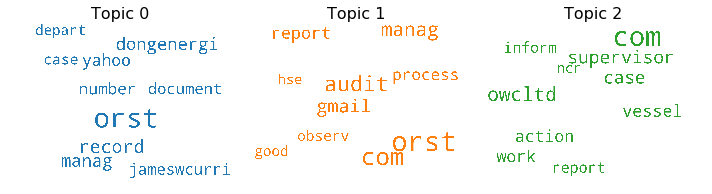

In [183]:
create_word_cloud_plt(comment_models[0], 3,'synergi_comments_three_topics')

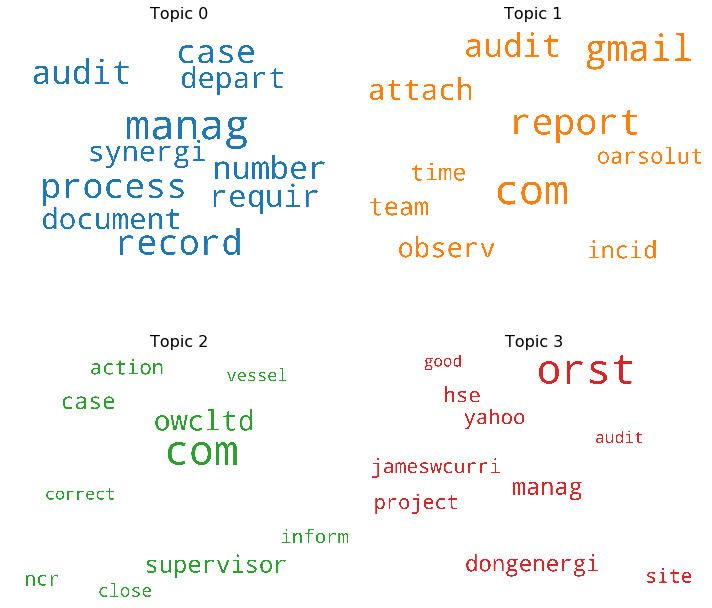

In [184]:
create_word_cloud_plt(comment_models[1], 4,'synergi_comments_four_topics')

---

### Title WordClouds

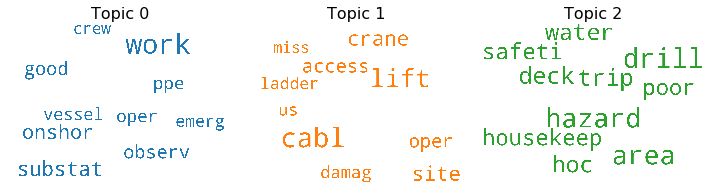

In [187]:
create_word_cloud_plt(title_models[1], 3,'synergi_title_three_topics')

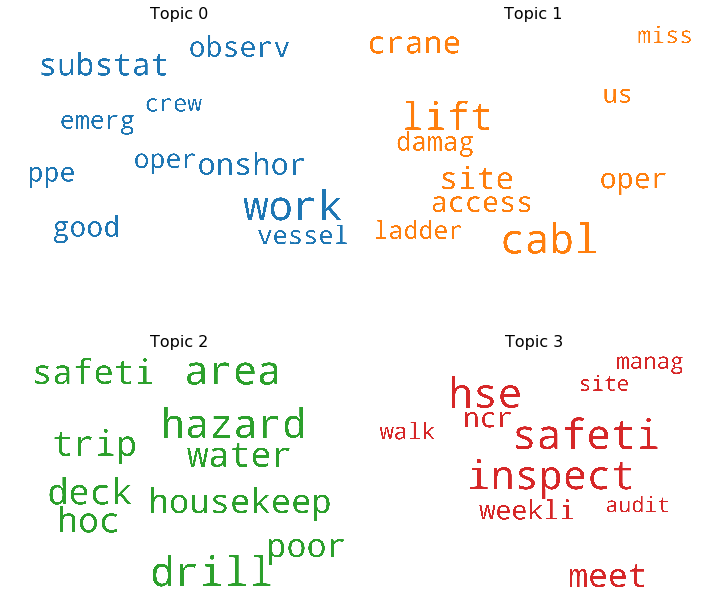

In [188]:
create_word_cloud_plt(title_models[1], 4,'synergi_title_four_topics')

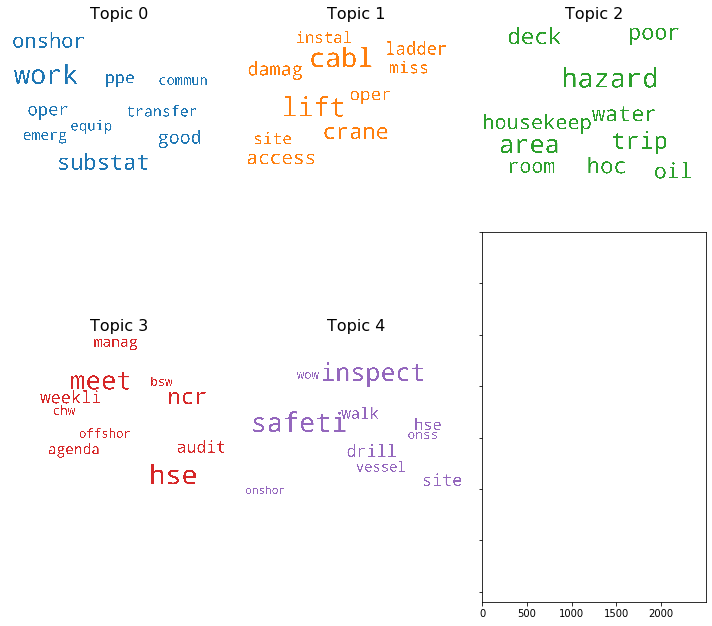

In [191]:
create_word_cloud_plt(title_models[2], 5,'synergi_title_five_topics')

---

### Description Word Clouds

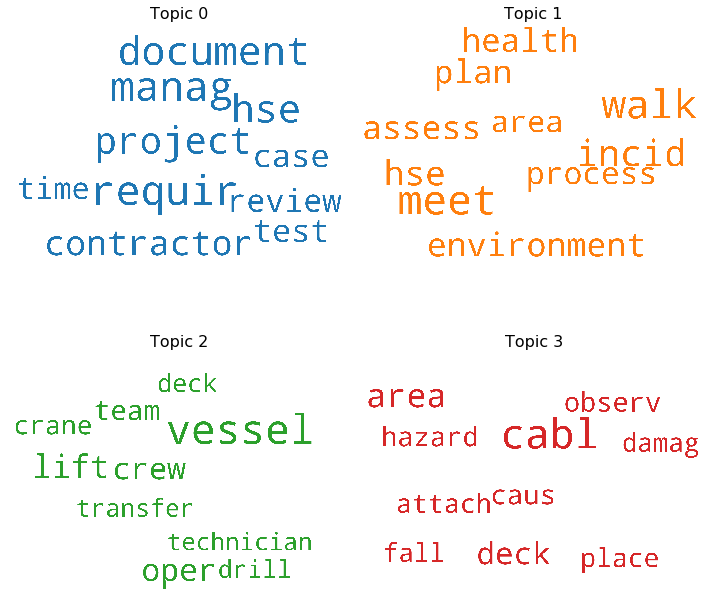

In [196]:
create_word_cloud_plt(description_models[0], 4,'synergi_description_four_topics')

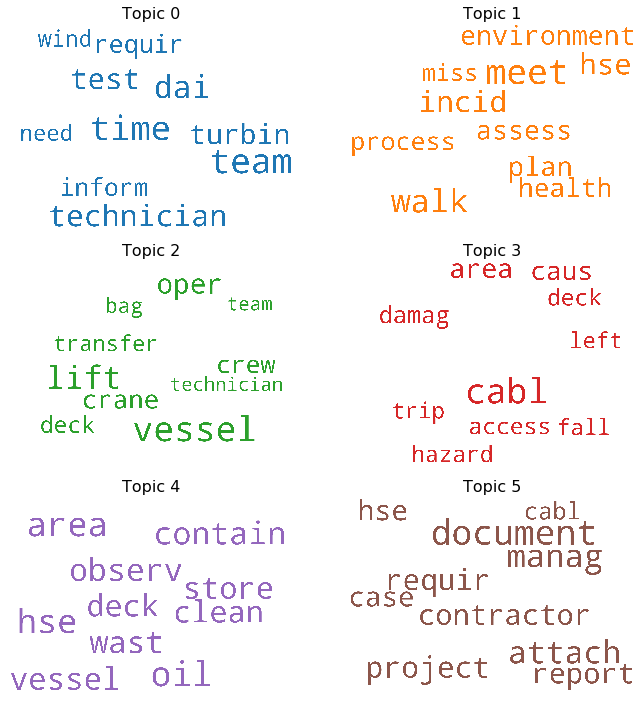

In [197]:
create_word_cloud_plt(description_models[1], 6,'synergi_description_six_topics')

both four and six topics look fine (some minor word overlaps as e.g. 'area' appearing at least twice for six topics.

---

for now, some words in the wordclouds look weird. Hence, in later steps text cleaning can be improved. For instance, Schofield et. al (2017) say that stemming may be redundant for LDA models, likewise stop word removal. After checking classifier performance, try different text preprocessing for new results.

## Appending the dominant topic column for the chosen models

In [ ]:
# chosen models depend upon our human decision-making based on the word cloud and pyLDAvis results :)

### Outputting different model results to .csv

In [208]:
column_names

['title_cleaned', 'description_cleaned', 'comments_cleaned']

In [211]:
# for four description 
topics_sentences_descr_four = format_topics_sentences(ldamodel=description_results[2][2],corpus=description_results[2][0],texts=corpus_list[1])

we are at 9.0282 per cent progress currently
we are at 18.0564 per cent progress currently
we are at 27.0846 per cent progress currently
we are at 36.1128 per cent progress currently
we are at 45.1410 per cent progress currently
we are at 54.1692 per cent progress currently
we are at 63.1974 per cent progress currently
we are at 72.2256 per cent progress currently
we are at 81.2538 per cent progress currently
we are at 90.2820 per cent progress currently
we are at 99.3102 per cent progress currently


In [212]:
topics_sentences_descr_four.head(1)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0  0            2.0             0.8831               

                                                                   Keywords  \
0  vessel, lift, oper, crew, team, crane, deck, drill, transfer, technician   

                                                                                                                                                                                                                                                                                                                                                                                                                                        Text  
0  [whilst, bullbai, push, push, tube, central, fender, loos, free, main, fender, hous, deckhand, inform, master, push, seiz, immedi, bullbai, report, damag, site, manag, agre, bullbai, head, ashor, damag, assess, drop, equip, regina, baltica, transfer, equip, regina, baltica, readi, damag, fender, came, complet, free, hous, drop, water, equip, transfer, safe, bullbai, proceed, shore, fender, retriev, vessel, oshor, bullbai]

In [215]:
topics_sentences_descr_four.to_csv('topics_sentences_descr_four.csv', index=False)

In [216]:
# for six description 
topics_sentences_descr_six = format_topics_sentences(ldamodel=description_results[4][2],corpus=description_results[4][0],texts=corpus_list[1])

we are at 9.0282 per cent progress currently
we are at 18.0564 per cent progress currently
we are at 27.0846 per cent progress currently
we are at 36.1128 per cent progress currently
we are at 45.1410 per cent progress currently
we are at 54.1692 per cent progress currently
we are at 63.1974 per cent progress currently
we are at 72.2256 per cent progress currently
we are at 81.2538 per cent progress currently
we are at 90.2820 per cent progress currently
we are at 99.3102 per cent progress currently


In [217]:
topics_sentences_descr_six.tail(1)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
110763  110763       1.0             0.6915               

                                                                        Keywords  \
110763  meet, walk, incid, hse, plan, assess, environment, health, process, miss   

                                         Text  
110763  [talk, phone, walk, near, work, area]

In [219]:
topics_sentences_descr_six.to_csv('topics_sentences_descr_six.csv', index=False)

In [221]:
# for comments three
topics_sentences_comments_three = format_topics_sentences(ldamodel=comment_results[1][2],corpus=comment_results[1][0],texts=corpus_list[2])

we are at 9.0282 per cent progress currently
we are at 18.0564 per cent progress currently
we are at 27.0846 per cent progress currently
we are at 36.1128 per cent progress currently
we are at 45.1410 per cent progress currently
we are at 54.1692 per cent progress currently
we are at 63.1974 per cent progress currently
we are at 72.2256 per cent progress currently
we are at 81.2538 per cent progress currently
we are at 90.2820 per cent progress currently
we are at 99.3102 per cent progress currently


In [222]:
topics_sentences_comments_three.tail(1)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
110763  110763       1.0             0.8391               

                                                                  Keywords  \
110763  orst, com, audit, manag, gmail, report, process, observ, good, hse   

                                          Text  
110763  [inform, foreman, conduct, train, tbm]

In [231]:
topics_sentences_comments_three.to_csv('topics_sentences_comment_three.csv', index=False)

In [223]:
# for comments four
topics_sentences_comments_four = format_topics_sentences(ldamodel=comment_results[2][2],corpus=comment_results[2][0],texts=corpus_list[2])

we are at 9.0282 per cent progress currently
we are at 18.0564 per cent progress currently
we are at 27.0846 per cent progress currently
we are at 36.1128 per cent progress currently
we are at 45.1410 per cent progress currently
we are at 54.1692 per cent progress currently
we are at 63.1974 per cent progress currently
we are at 72.2256 per cent progress currently
we are at 81.2538 per cent progress currently
we are at 90.2820 per cent progress currently
we are at 99.3102 per cent progress currently


In [224]:
topics_sentences_comments_four.tail(1)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
110763  110763       1.0             0.841                

                                                                      Keywords  \
110763  com, report, gmail, audit, attach, observ, team, incid, time, oarsolut   

                                          Text  
110763  [inform, foreman, conduct, train, tbm]

In [232]:
topics_sentences_comments_four.to_csv('topics_sentences_comment_four.csv', index=False)

In [225]:
# for title three
topics_sentences_title_three = format_topics_sentences(ldamodel=title_results[1][2],corpus=title_results[1][0],texts=corpus_list[0])

we are at 9.0282 per cent progress currently
we are at 18.0564 per cent progress currently
we are at 27.0846 per cent progress currently
we are at 36.1128 per cent progress currently
we are at 45.1410 per cent progress currently
we are at 54.1692 per cent progress currently
we are at 63.1974 per cent progress currently
we are at 72.2256 per cent progress currently
we are at 81.2538 per cent progress currently
we are at 90.2820 per cent progress currently
we are at 99.3102 per cent progress currently


In [226]:
topics_sentences_title_three.tail(1)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
110763  110763       0.0             0.5685               

                                                                   Keywords  \
110763  work, substat, onshor, hse, inspect, good, manag, observ, wtg, oper   

                                 Text  
110763  [basic, safeti, rule, violat]

In [233]:
topics_sentences_title_three.to_csv('topics_sentences_title_three.csv', index=False)

In [227]:
# for title four
topics_sentences_title_four = format_topics_sentences(ldamodel=title_results[2][2],corpus=title_results[2][0],texts=corpus_list[0])

we are at 9.0282 per cent progress currently
we are at 18.0564 per cent progress currently
we are at 27.0846 per cent progress currently
we are at 36.1128 per cent progress currently
we are at 45.1410 per cent progress currently
we are at 54.1692 per cent progress currently
we are at 63.1974 per cent progress currently
we are at 72.2256 per cent progress currently
we are at 81.2538 per cent progress currently
we are at 90.2820 per cent progress currently
we are at 99.3102 per cent progress currently


In [228]:
topics_sentences_title_four.tail(1)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
110763  110763       3.0             0.8461               

                                                                 Keywords  \
110763  safeti, hse, inspect, meet, ncr, weekli, walk, manag, audit, site   

                                 Text  
110763  [basic, safeti, rule, violat]

In [234]:
topics_sentences_title_four.to_csv('topics_sentences_title_four.csv', index=False)

In [229]:
# for title five
topics_sentences_title_five = format_topics_sentences(ldamodel=title_results[3][2],corpus=title_results[3][0],texts=corpus_list[0])

we are at 9.0282 per cent progress currently
we are at 18.0564 per cent progress currently
we are at 27.0846 per cent progress currently
we are at 36.1128 per cent progress currently
we are at 45.1410 per cent progress currently
we are at 54.1692 per cent progress currently
we are at 63.1974 per cent progress currently
we are at 72.2256 per cent progress currently
we are at 81.2538 per cent progress currently
we are at 90.2820 per cent progress currently
we are at 99.3102 per cent progress currently


In [230]:
topics_sentences_title_five.tail(1)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
110763  110763       0.0             0.5064               

                                                                      Keywords  \
110763  work, substat, onshor, good, oper, ppe, transfer, emerg, equip, commun   

                                 Text  
110763  [basic, safeti, rule, violat]

In [235]:
topics_sentences_title_five.to_csv('topics_sentences_title_five.csv', index=False)